In [1]:
%load_ext autoreload
%autoreload 2

# Orthogonality of sRNA in mRNA targetting

## Imports

In [2]:
import os
from subprocess import Popen, PIPE, run
import re
from datetime import datetime
import pandas as pd
import logging

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.IntaRNA.bin.copomus.IntaRNA import IntaRNA
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA
from synbio_morpher.utils.misc.type_handling import flatten_listlike

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/jaxtyping/__init__.py:221: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


# Load data

In [3]:
fn_merged_inter = os.path.join('..', 'data', 'sRNA', 'merged_inter.csv')
# fn_merged_inter = os.path.join('..', 'data', 'sRNA', 'merged_EcoCyc_RNAInter_sRNATarBase.csv')
data = pd.read_csv(fn_merged_inter)
try:
    data = data.drop(columns=['Unnamed: 0', 'level_0'])
except:
    pass

data = data[~data['Sequence 1'].isna()]
data = data[~data['Sequence 2'].isna()]
data = data.drop(columns=['Unnamed: 0'])

In [4]:
data[data['Interactor 1'] == 'ryhB']['Sequence 1'].unique()

array(['GCGATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCTCACATTGCTTCCAGTATTACTTAGCCAGCCGGGTGCTGGCTTTT'],
      dtype=object)

In [5]:
print(len(data))
nn = np.sum(np.arange(1, len(data)+1)) + len(data)
print('Expected number of species: ', nn)
data

378
Expected number of species:  72009


,Interactor 1,Interactor 2,ID 1,ID 2,Category 1,Category 2,Regulation,Binding position 1,Binding position 2,Sequence 1,Sequence 2,Source DB,Genome position 1,Genome position 2,Strand 1,Strand 2,Sequence before 1,Sequence before 2,Sequence after 1,Sequence after 2
0,dsrA,dsrB,NCBI:946470,NCBI:946468,sRNA,mRNA,NaN,NaN,NaN,AACACATCAGATTTCCTGGTGTAACGAATTTTTTAAGTGCTTCTTG...,TAAATGNAAACAAGTTTTATTTTTATCATCAGAACATTCTAATAAA...,RNAInter,NaN,NaN,NaN,NaN,ttcatcaccttatccgcaatttttttcgctgacaagaaaatattcg...,atcgttttcctcctgtggctttgtgccagtgtagaacaatttcgtt...,cgtgaggtcagcgtcgatgtcgatgccctgctggcggcgatcaatg...,NaN
1,dsrA,ilvH,NCBI:946470,NCBI:947267,sRNA,mRNA,NaN,NaN,NaN,AACACATCAGATTTCCTGGTGTAACGAATTTTTTAAGTGCTTCTTG...,ATTCGCCACAACAAGGACAGGAAGGTTCGGCGCAAGGAGCCCAAGA...,RNAInter,NaN,NaN,NaN,NaN,ttcatcaccttatccgcaatttttttcgctgacaagaaaatattcg...,ATTCGCCACAACAAGGACAGGAAGGTTCGGCGCAAGGAGCCCAAGA...,cgtgaggtcagcgtcgatgtcgatgccctgctggcggcgatcaatg...,ATTCGCCACAACAAGGACAGGAAGGTTCGGCGCAAGGAGCCCAAGA...
2,oxyS,fhlA,NCBI:2847701,NCBI:947181,sRNA,mRNA,NaN,NaN,NaN,GAAACGGAGCGGCACCTCTTTTAACCCTTGAAGTCACTGCCCGTTT...,CACCAGATTGCCAAGCTGATGGTCGAGCTGTCCAAATCCCAGGATG...,RNAInter,NaN,NaN,NaN,NaN,TTTGCGAACTTATCGGTTTCGTATTGAGGGCAATAAACTCTCGAGG...,CACCAGATTGCCAAGCTGATGGTCGAGCTGTCCAAATCCCAGGATG...,TTTGCGAACTTATCGGTTTCGTATTGAGGGCAATAAACTCTCGAGG...,CACCAGATTGCCAAGCTGATGGTCGAGCTGTCCAAATCCCAGGATG...
3,sgrS,hfq,NCBI:4056038,NCBI:948689,sRNA,mRNA,NaN,NaN,NaN,GATGAAGCAAGGGGGTGCCCCATGCGTCAGTTTTATCAGCACTATT...,ATGGCTAAGGGGCAATCTTTACAAGATCCGTTCCTGAACGCACTGC...,RNAInter,NaN,NaN,NaN,NaN,ttgagcagggtgcgcatatgacgacgcgagcagctcaataacgctg...,cgaagcggcagataacctggctgcgtggttgggaaggggttcactg...,ttattctcgccgcgctaaaaagggaacgtatgatctggataatgac...,aaggtttcgggctgtttttttacacggggagccagcgatcctgcgt...
4,oxyS,nusG,NCBI:2847701,NCBI:948485,sRNA,mRNA,NaN,NaN,NaN,GAAACGGAGCGGCACCTCTTTTAACCCTTGAAGTCACTGCCCGTTT...,ATGTCTGAAGCTCCTAAAAAGCGCTGGTACGTCGTTCAGGCGTTTT...,RNAInter,NaN,NaN,NaN,NaN,TTTGCGAACTTATCGGTTTCGTATTGAGGGCAATAAACTCTCGAGG...,cgacaaaaggtaaagctaccgttgcttttgcccgtgaagcgcgtac...,TTTGCGAACTTATCGGTTTCGTATTGAGGGCAATAAACTCTCGAGG...,aacccagcgatcaaaaaagcggcgatttaatcgttgcacaaggcgt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,ryhB,msrA,"chromosome:NC_000913.3, Gene ID:2847761","chromosome:NC_000913.3, Gene ID:948734",sRNA,mRNA,No Interaction,['NA'],['NA'],GCGATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCT...,ATGAGTTTATTTGATAAAAAGCATCTGGTTTCCCCCGCCGATGCCC...,sRNATarBase,3580927..3581016,4441538..4442176,reverse,reverse,TTTGAGAGCGTCTCTGTCCCTCGTTTTGCGGTTAAGCCGCATCCAT...,atggtgtcgctctcccgaaaatcggtcattggggttaaggttgtaa...,TTTGAGAGCGTCTCTGTCCCTCGTTTTGCGGTTAAGCCGCATCCAT...,aggtactgtaaagccgccagagggttaaaattcagacagctgaaaa...
374,gcvB,hdeA,"chromosome:NC_000913.3, Gene ID:2847720","chromosome:NC_000913.3, Gene ID:948025",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],ACTTCCTGAGCCGGAACGAAAAGTTTTATCGGAATGCGTGTTCTGG...,ATGAAAAAAGTATTAGGCGTTATTCTTGGTGGTCTGCTTCTTCTGC...,sRNATarBase,2942696..2942901,3656408..3656740,forward,reverse,GGTAGAGCGCCATTGCATTCTTTAGCGCCTCGATCCCTTTATTTTT...,atcgtaatatcctcaactataaagtgaaagagccgtcacgaatcaa...,GGTAGAGCGCCATTGCATTCTTTAGCGCCTCGATCCCTTTATTTTT...,gccaacgcagattgtgcgttcaccagtgacaaagccgctacagcgc...
375,gcvB,hdeB,"chromosome:NC_000913.3, Gene ID:2847720","chromosome:NC_000913.3, Gene ID:948026",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],ACTTCCTGAGCCGGAACGAAAAGTTTTATCGGAATGCGTGTTCTGG...,ATGAATATTTCATCTCTCCGTAAAGCGTTTATTTTTATGGGCGCTG...,sRNATarBase,2942696..2942901,3655966..3656292,forward,reverse,GGTAGAGCGCCATTGCATTCTTTAGCGCCTCGATCCCTTTATTTTT...,attttgtaacccattcaatatagagattatatatgaacaggaggaa...,GGTAGAGCGCCATTGCATTCTTTAGCGCCTCGATCCCTTTATTTTT...,cataaacagggcgcttcccatgccaattaatacatgtgtgcgtaac...
376,Esr41,fliC,"chromosome:NC_002695.1, Gene ID:","chromosome:NC_002695.1, Gene ID:",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],GATGCTCTAGGCATCACATTTTCTCCATGGGGTATTCCCTCCGCCG...,ATGGCACAAGTCATTAATACCAACAGCCTCTCGCTGATCACTCAAA...,sRNATarBa

# Get mRNAs and sRNAs

In [6]:
data['Category 1'].unique()

array(['sRNA', 'pseudo', 'trans-encoded antisense RNA', 'Protein'],
      dtype=object)

In [7]:
data['Category 2'].unique()

array(['mRNA', 'sRNA'], dtype=object)

In [8]:
pattern = r'\s*\([^)]*\)'
for i in [1, 2]:
    data[f'Binding position {i}'] = list(map(lambda raw: flatten_listlike(
        [[[int(re.sub(pattern, '', bp)) for bp in bps.split('..')]
          for bps in re.sub(pattern, '', par).split('; ')] for par in raw if par.split('..')[0].strip('-').isnumeric()]), data[f'Binding position {i}'].apply(str).str.split("'")))

In [9]:
# srnas = list(set(data[data['Category 1'] != 'mRNA']['Interactor 1'].to_list() + data[data['Category 2'] != 'mRNA']['Interactor 2'].to_list()))
# mrnas = list(set(data[data['Category 1'] == 'mRNA']['Interactor 1'].to_list() + data[data['Category 2'] == 'mRNA']['Interactor 2'].to_list()))

srnas, mrnas = {}, {}
filt_srna1 = data['Category 1'].isin(['sRNA', 'trans-encoded antisense RNA', 'protein binding small RNA'])
filt_srna2 = data['Category 2'].isin(['sRNA', 'trans-encoded antisense RNA', 'protein binding small RNA']) & (~data['Category 1'].isin(['Protein']))
for i in [1, 2]:
    filt = filt_srna1 if i == 1 else filt_srna2
    for s in data[f'Interactor {i}'].unique():
        seq = data[data[f'Interactor {i}'] == s][f'Sequence {i}'].iloc[0]
        offset = data[data[f'Interactor {i}'] == s][f'Binding position {i}'].iloc[0]
        if offset:
            offset = np.min(offset)
            if offset < 0: 
                seq = data[data[f'Interactor {i}'] == s][f'Sequence before {i}'].iloc[0] + seq
        if s in data[data[f'Category {i}'] == 'mRNA'][f'Interactor {i}'].unique():
            mrnas[s] = seq.replace('T', 'U').replace('t', 'u')
        elif s in data[filt][f'Interactor {i}'].unique():
            srnas[s] = seq.replace('T', 'U').replace('t', 'u')
            

## Check that no sRNA's are overlapping with mRNAs

In [10]:
len(srnas) == (len(set(srnas.keys()) - set(mrnas.keys())))


True

Add the synthetic ChiX that Scott made:

In [11]:
fn_mutations = os.path.join('data', 'scott_mutations.fasta')
muts = load_seq_from_FASTA(fn_mutations, as_type='dict')


In [12]:
muts.keys()

dict_keys(['Syn_ChiX_20-D', 'MutagenesisVariant_1', 'MutagenesisVariant_2', 'MutagenesisVariant_3', 'MutagenesisVariant_4', 'MutagenesisVariant_5', 'MutagenesisVariant_6', 'MutagenesisVariant_7', 'MutagenesisVariant_8', 'MutagenesisVariant_9', 'MutagenesisVariant_10', 'MutagenesisVariant_11', 'MutagenesisVariant_12', 'MutagenesisVariant_13', 'MutagenesisVariant_14', 'MutagenesisVariant_15', 'MutagenesisVariant_16', 'MutagenesisVariant_17', 'MutagenesisVariant_18', 'MutagenesisVariant_19', 'MutagenesisVariant_20', 'MutagenesisVariant_21', 'MutagenesisVariant_22', 'MutagenesisVariant_23', 'MutagenesisVariant_24', 'MutagenesisVariant_25', 'MutagenesisVariant_26', 'MutagenesisVariant_27', 'MutagenesisVariant_28', 'MutagenesisVariant_29', 'MutagenesisVariant_30', 'MutagenesisVariant_31', 'MutagenesisVariant_32', 'MutagenesisVariant_33', 'MutagenesisVariant_34', 'MutagenesisVariant_35', 'MutagenesisVariant_36', 'MutagenesisVariant_37', 'MutagenesisVariant_38', 'MutagenesisVariant_39', 'Mutag

In [13]:
srnas['Syn_ChiX_20-D'] = muts['Syn_ChiX_20-D']

Make config to run IntaRNA simulations.

In [14]:

config = {
    "experiment": {
        "purpose": "tests",
        "no_visualisations": False,
        "no_numerical": False,
        "debug_mode": False
    },
    "data": {},
    "system_type": "RNA",
    "include_prod_deg": False,
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
            # "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
            "outcsvcols": "id1, id2, E, E_norm, subseqDB, Pu1, Pu2",
            "threads": 12,
            "n": 1,
            "raw_stdout": True
        }
    },
    "molecular_params_factor": 1,
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}

In [ ]:
data_writer = None
config, data_writer = script_preamble(config, data_writer)
config_file = expand_config(config=config)
config_file = prepare_config(config_file)

## Create circuits

In [36]:
len(srnas) * len(mrnas)

11004

In [ ]:
sim_data = {}

def simulate_IntaRNA_local(query: dict,
                           targets: dict,
                           sim_kwargs={}):
    fn1 = data_writer.output(data=query, out_type='fasta', out_name='query', byseq=True, return_path=True)
    fn2 = data_writer.output(data=targets, out_type='fasta', out_name='targets', byseq=True, return_path=True)
    sim_kwargs['query'] = fn1
    sim_kwargs['target'] = fn2
    
    def run(query: str, target: str, qidxpos0: int, tidxpos0: int, outcsvcols: str, threads: int, n: int = 1,
            param_file: str = '', extra_params: list = [], raw_stdout: bool = False):
        p = Popen(['IntaRNA', '-q', query, '-t', target,
                    '--outMode=C', f'--outcsvcols={outcsvcols}',
                    f'--qIdxPos0={qidxpos0}',
                    f'--tIdxPos0={tidxpos0}',
                    f'--outNumber={n}',
                    f'--threads={threads}', param_file]
                    + extra_params, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        stdout, stderr = p.communicate()
        return process_raw_stdout(stdout)
    
    return run(**sim_kwargs)


for s, sseq in srnas.items():
    sim_data[s] = {}
    t = datetime.now()

    sim_data[s] = simulate_IntaRNA_local(query={s: sseq},
                                         targets=mrnas,
                                         sim_kwargs=config_file['interaction_simulator']['simulator_kwargs'])
    # print('Finished ', s, ' in ', (datetime.now() - t).total_seconds(), ' s')
    logging.warning('Finished ', s, ' in ', (datetime.now() - t).total_seconds(), ' s')

    data_writer.output(data=sim_data, out_type='json',
                       out_name='inter_data_raw', overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: 'IntaRNA'

In [ ]:
print(data_writer.write_dir)

# Load simulation results

In [15]:
# fn = './data/05_orthogonality_mRNA_official/2023_11_08_145023/inter_data_raw.json'
# fn = './data/05_orthogonality_mRNA_official/2023_11_21_095238/inter_data_raw.json'
# fn = './data/05_orthogonality_mRNA_official/2023_12_04_120211/inter_data_raw.json'
fn = './data/05_orthogonality_mRNA_official/2024_01_04_105924/inter_data_raw.json'

sim_data_l = load_json_as_dict(fn)

In [16]:
len(srnas)

43

In [17]:
len(sim_data_l)

234

In [18]:
sim_data_l = {k: v for k, v in sim_data_l.items() if k in srnas.keys()}

In [19]:
k1 = list(sim_data_l.keys())[0]
k2 = list(sim_data_l[k1].keys())[0]
header = list(sim_data_l[k1][k2].keys())
header

['id1', 'id2', 'E', 'E_norm', 'subseqDB', 'Pu1', 'Pu2']

In [20]:
sim_data_l[k1][k2]

{'id1': 'ecnB',
 'id2': 'dsrA',
 'E': '-2.56',
 'E_norm': '-0.270718',
 'subseqDB': '39GGUGCUU&35AAGUGCU',
 'Pu1': '0.0835363',
 'Pu2': '0.0745675'}

In [21]:
default_vals = {
    'id1': '', 'id2': '', 'E': 0.0, 'E_norm': 0.0, 'subseqDB': '', 'bpList': '', 'hybridDPfull': '', 'Pu1': 0.0, 'Pu2': 0.0, 'seedPu1': '', 'seedPu2': '', 'seedStart1': '', 'seedStart2': '', 'seedEnd1': '', 'seedEnd2': ''
}

Need to add zeros back in, since IntaRNA just excludes runs where the binding energy is zero kcal.

In [22]:
mrnas_set = set(mrnas.keys())
for s, v in sim_data_l.items():
    mrnas_set = set(list(mrnas_set) + list(v.keys()))
for s, v in sim_data_l.items():
    if len(mrnas_set) != len(mrnas):
        diffs = mrnas_set - set(v.keys())
        for d in diffs:
            sim_data_l[s][d] = default_vals
        

In [23]:
len(mrnas)

262

In [24]:
list(sim_data_l.keys())[-1]

'Syn_ChiX_20-D'

In [25]:
sim_data_l.keys()

dict_keys(['dsrA', 'oxyS', 'sgrS', 'ryhB', 'sdsR', 'micF', 'micC', 'istR', 'omrA', 'omrB', 'rprA', 'rseX', 'rybB', 'Spot_42', 'cyaR', 'dicF', 'gadY', 'symR', 'sokB', 'sokC', 'gcvB', 'rdlD', 'fnrS', 'sibC', 'arcZ', 'sibB', 'mgrR', 'chiX', 'mcaS', 'ohsC', 'OrzO', 'sibD', 'sibE', 'sibA', 'IpeX', 'rdlA', 'rdlB', 'rdlC', 'arrS', 'mntS', 'AfaR', 'Esr41', 'Syn_ChiX_20-D'])

In [26]:
# This a protein
# srnas['rpoD']

In [27]:
mrnas['gpmA']

'UCCCCCGUGUAGAUCAGGUCGAUGAGUCACCGCGUUCCCACGGGUGACCGUGGCGGUGGCUUCGUUGGUGGCCUACCGUGGGGACACCCACAGGACGCUCUAAUACAGACAUGGUGCGAAGAGUCUAUUGAGCUAGUUGGUAGUCUCCGGCCCCUGAAUGCGGCUAAUCCUAACUGCGGAGCAUGCACCCACAAGCCAGUGGGUAGCGUGUCGUAACGGGCAACUCUGCAGCGGAACCGACUACUUUGGGUGACCGUGUUUCUCUUUAUUCUCUCAUUGGCUGCUUAUGGUGACAAUAUGGCUGUAACUAAGCUGGUUCUGGUUCGUCAUGGCGAAAGUCAGUGGAACAAAGAAAACCGUUUCACCGGUUGGUACGACGUGGAUCUGUCUGAGAAAGGCGUAAGCGAAGCAAAAGCAGCAGGUAAGCUGCUGAAAGAGGAAGGUUACAGCUUUGACUUUGCUUACACUUCUGUGCUGAAACGCGCUAUCCAUACCCUGUGGAAUGUGCUGGACGAACUGGAUCAGGCAUGGCUGCCCGUUGAGAAAUCCUGGAAACUGAACGAACGUCACUACGGUGCGUUGCAGGGUCUGAACAAAGCGGAAACUGCUGAAAAGUAUGGCGACGAGCAGGUGAAACAGUGGCGUCGUGGUUUUGCAGUGACUCCGCCGGAACUGACUAAAGAUGAUGAGCGUUAUCCGGGUCACGAUCCGCGUUACGCGAAACUGAGCGAGAAAGAACUGCCGCUGACGGAAAGCCUGGCGCUGACCAUUGACCGCGUGAUCCCUUACUGGAAUGAAACUAUUCUGCCGCGUAUGAAGAGCGGUGAGCGCGUGAUCAUCGCUGCACACGGUAACUCUUUACGUGCGCUGGUGAAAUAUCUUGAUAACAUGAGCGAAGAAGAGAUUCUUGAGCUUAAUAUCCCGACUGGCGUGCCGCUGGUGUAUGAGUUCGACGAGAAUUUCAAACCGCUGAAACGCUAUUAUCUGGGUAAUGCUGAC

## Create IntaRNA variable dataframes

In [28]:
energies = pd.DataFrame(data=np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l.values()]).T,
                        columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))
energies_norm = pd.DataFrame(data=np.array([[float(vv['E_norm']) for vv in v.values()] for v in sim_data_l.values()]).T,
                             columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))

### Energy cluster

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2100x2700 with 0 Axes>

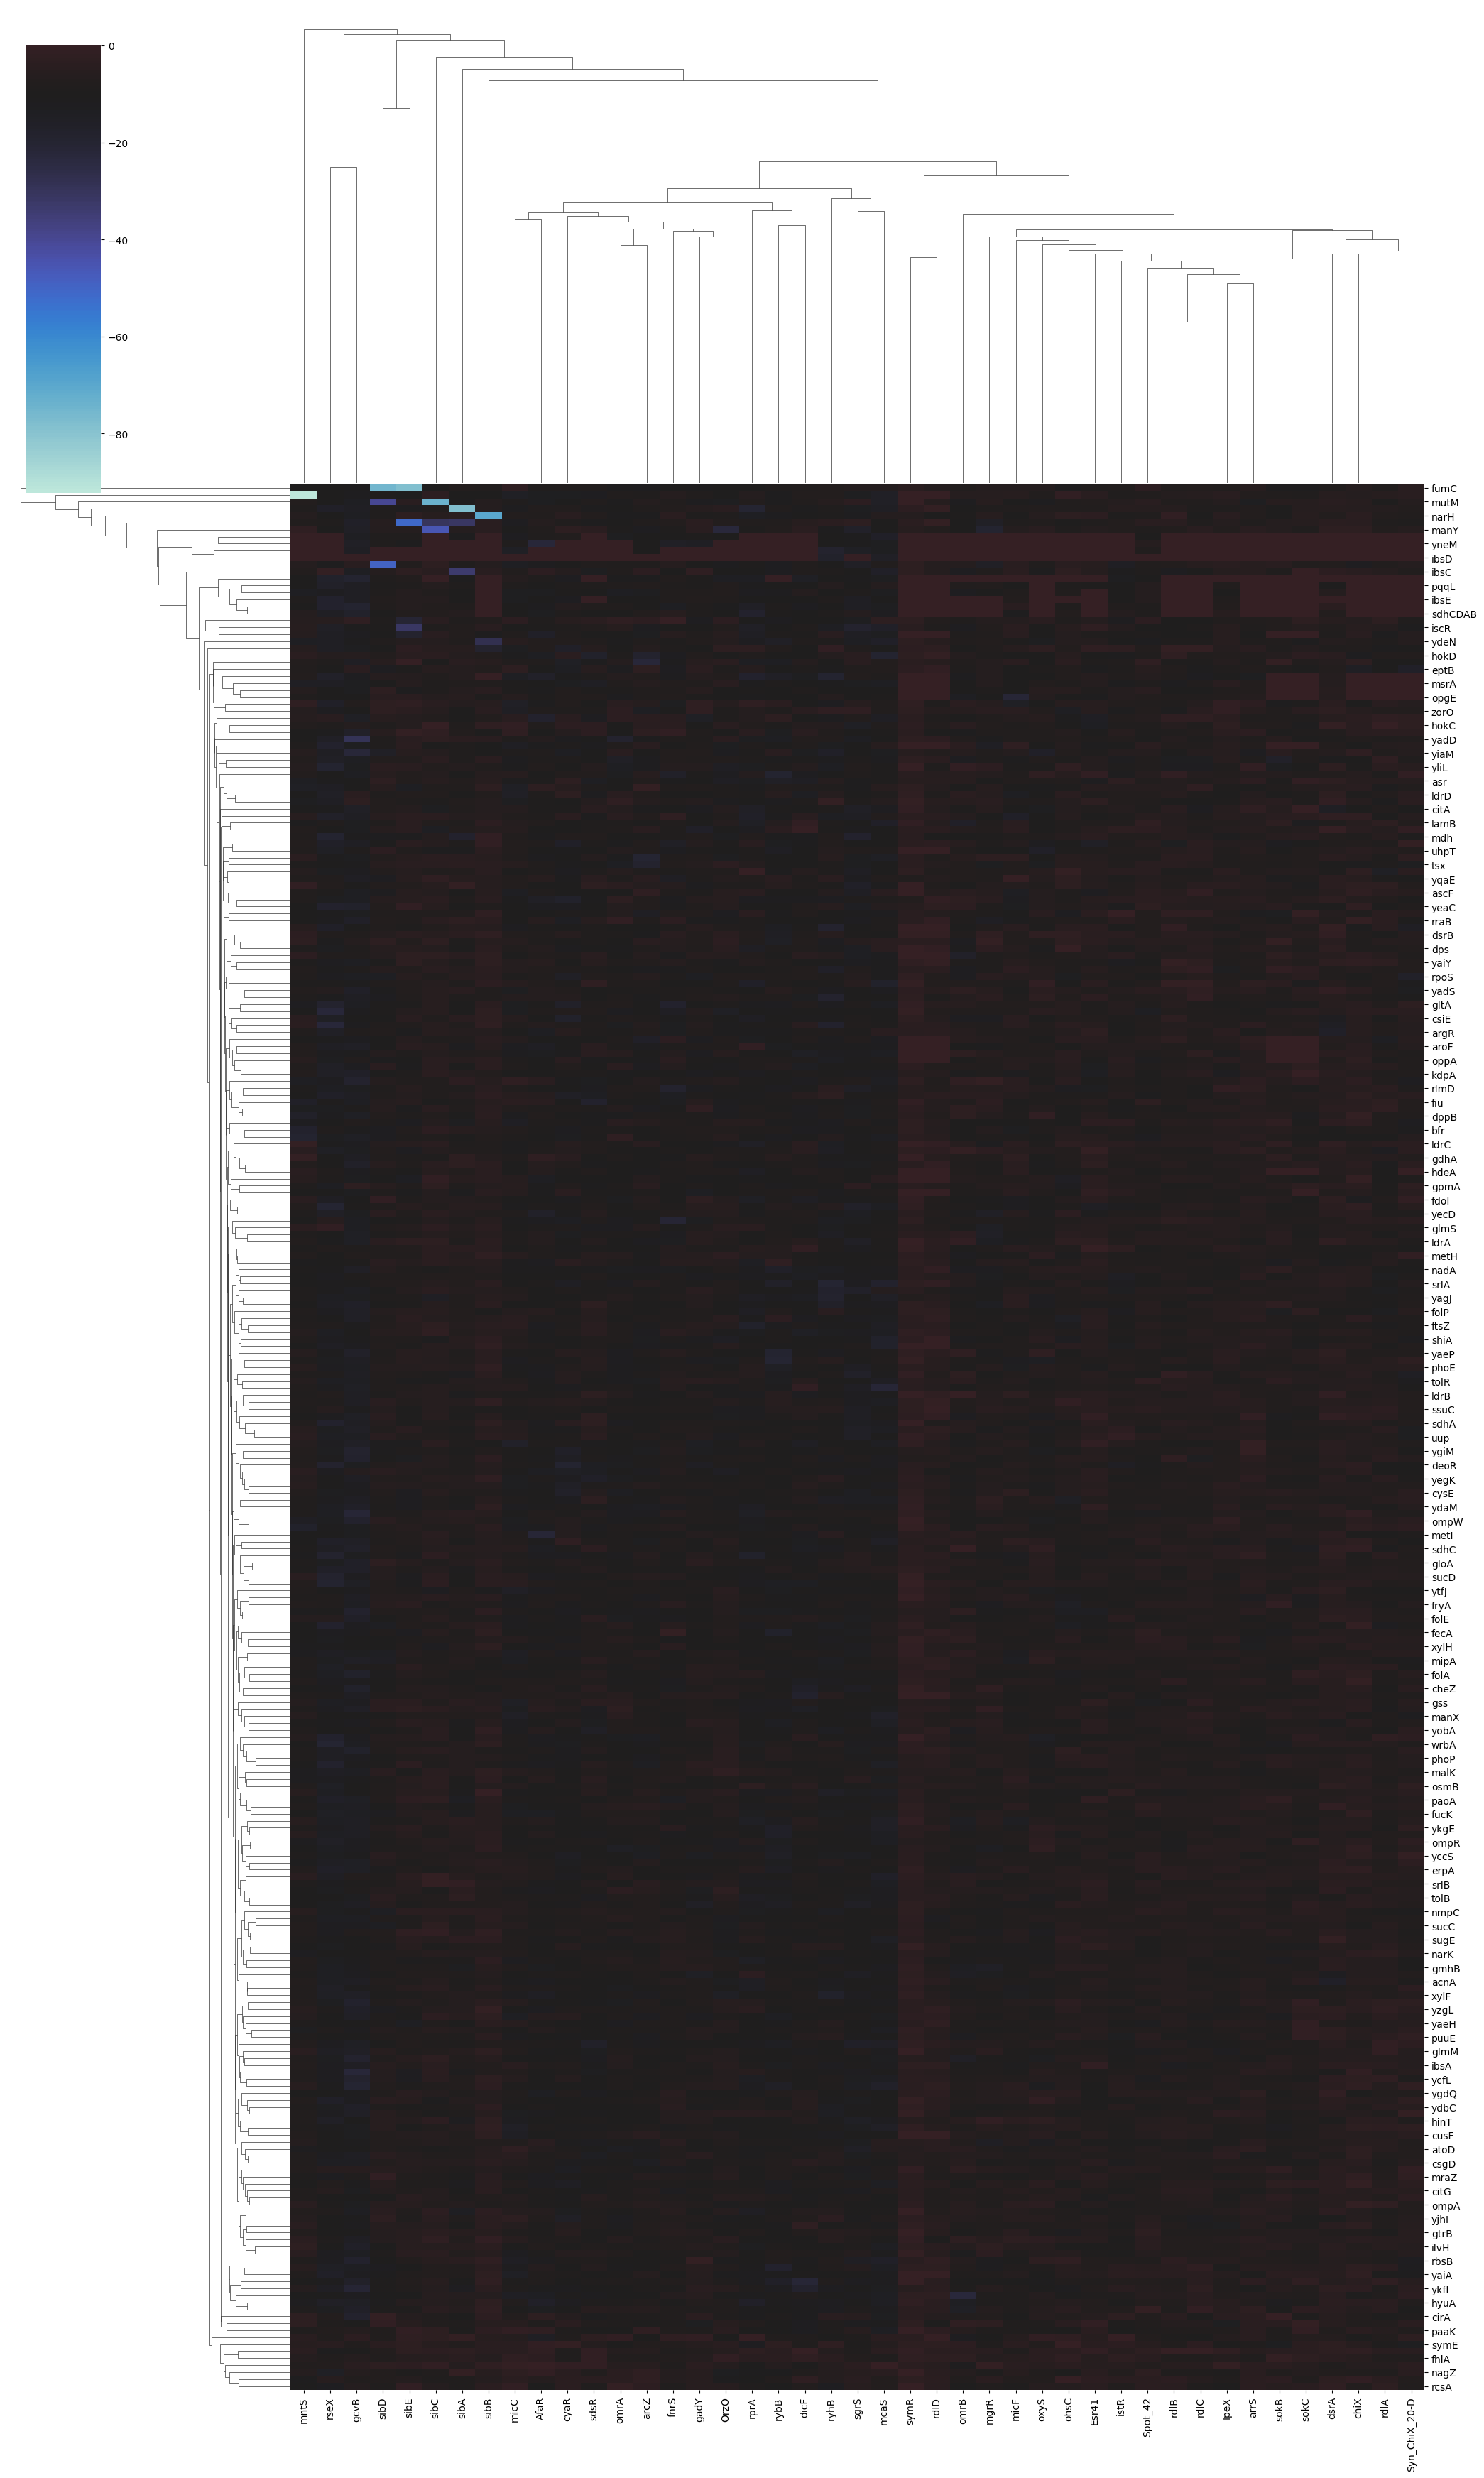

In [29]:
fig = plt.figure(figsize=(21, 27))
sns.clustermap(energies, center=-10, figsize=(21, 35), cmap= 'icefire') # Spectral, cubehelix, vlag
# plt.title('sRNA (bottom) interaction with known mRNA targets (side) binding energies (kcal)')

plt.savefig('data/figs/mRNA_official_energies_cluster.jpg')

### Energy heatmap

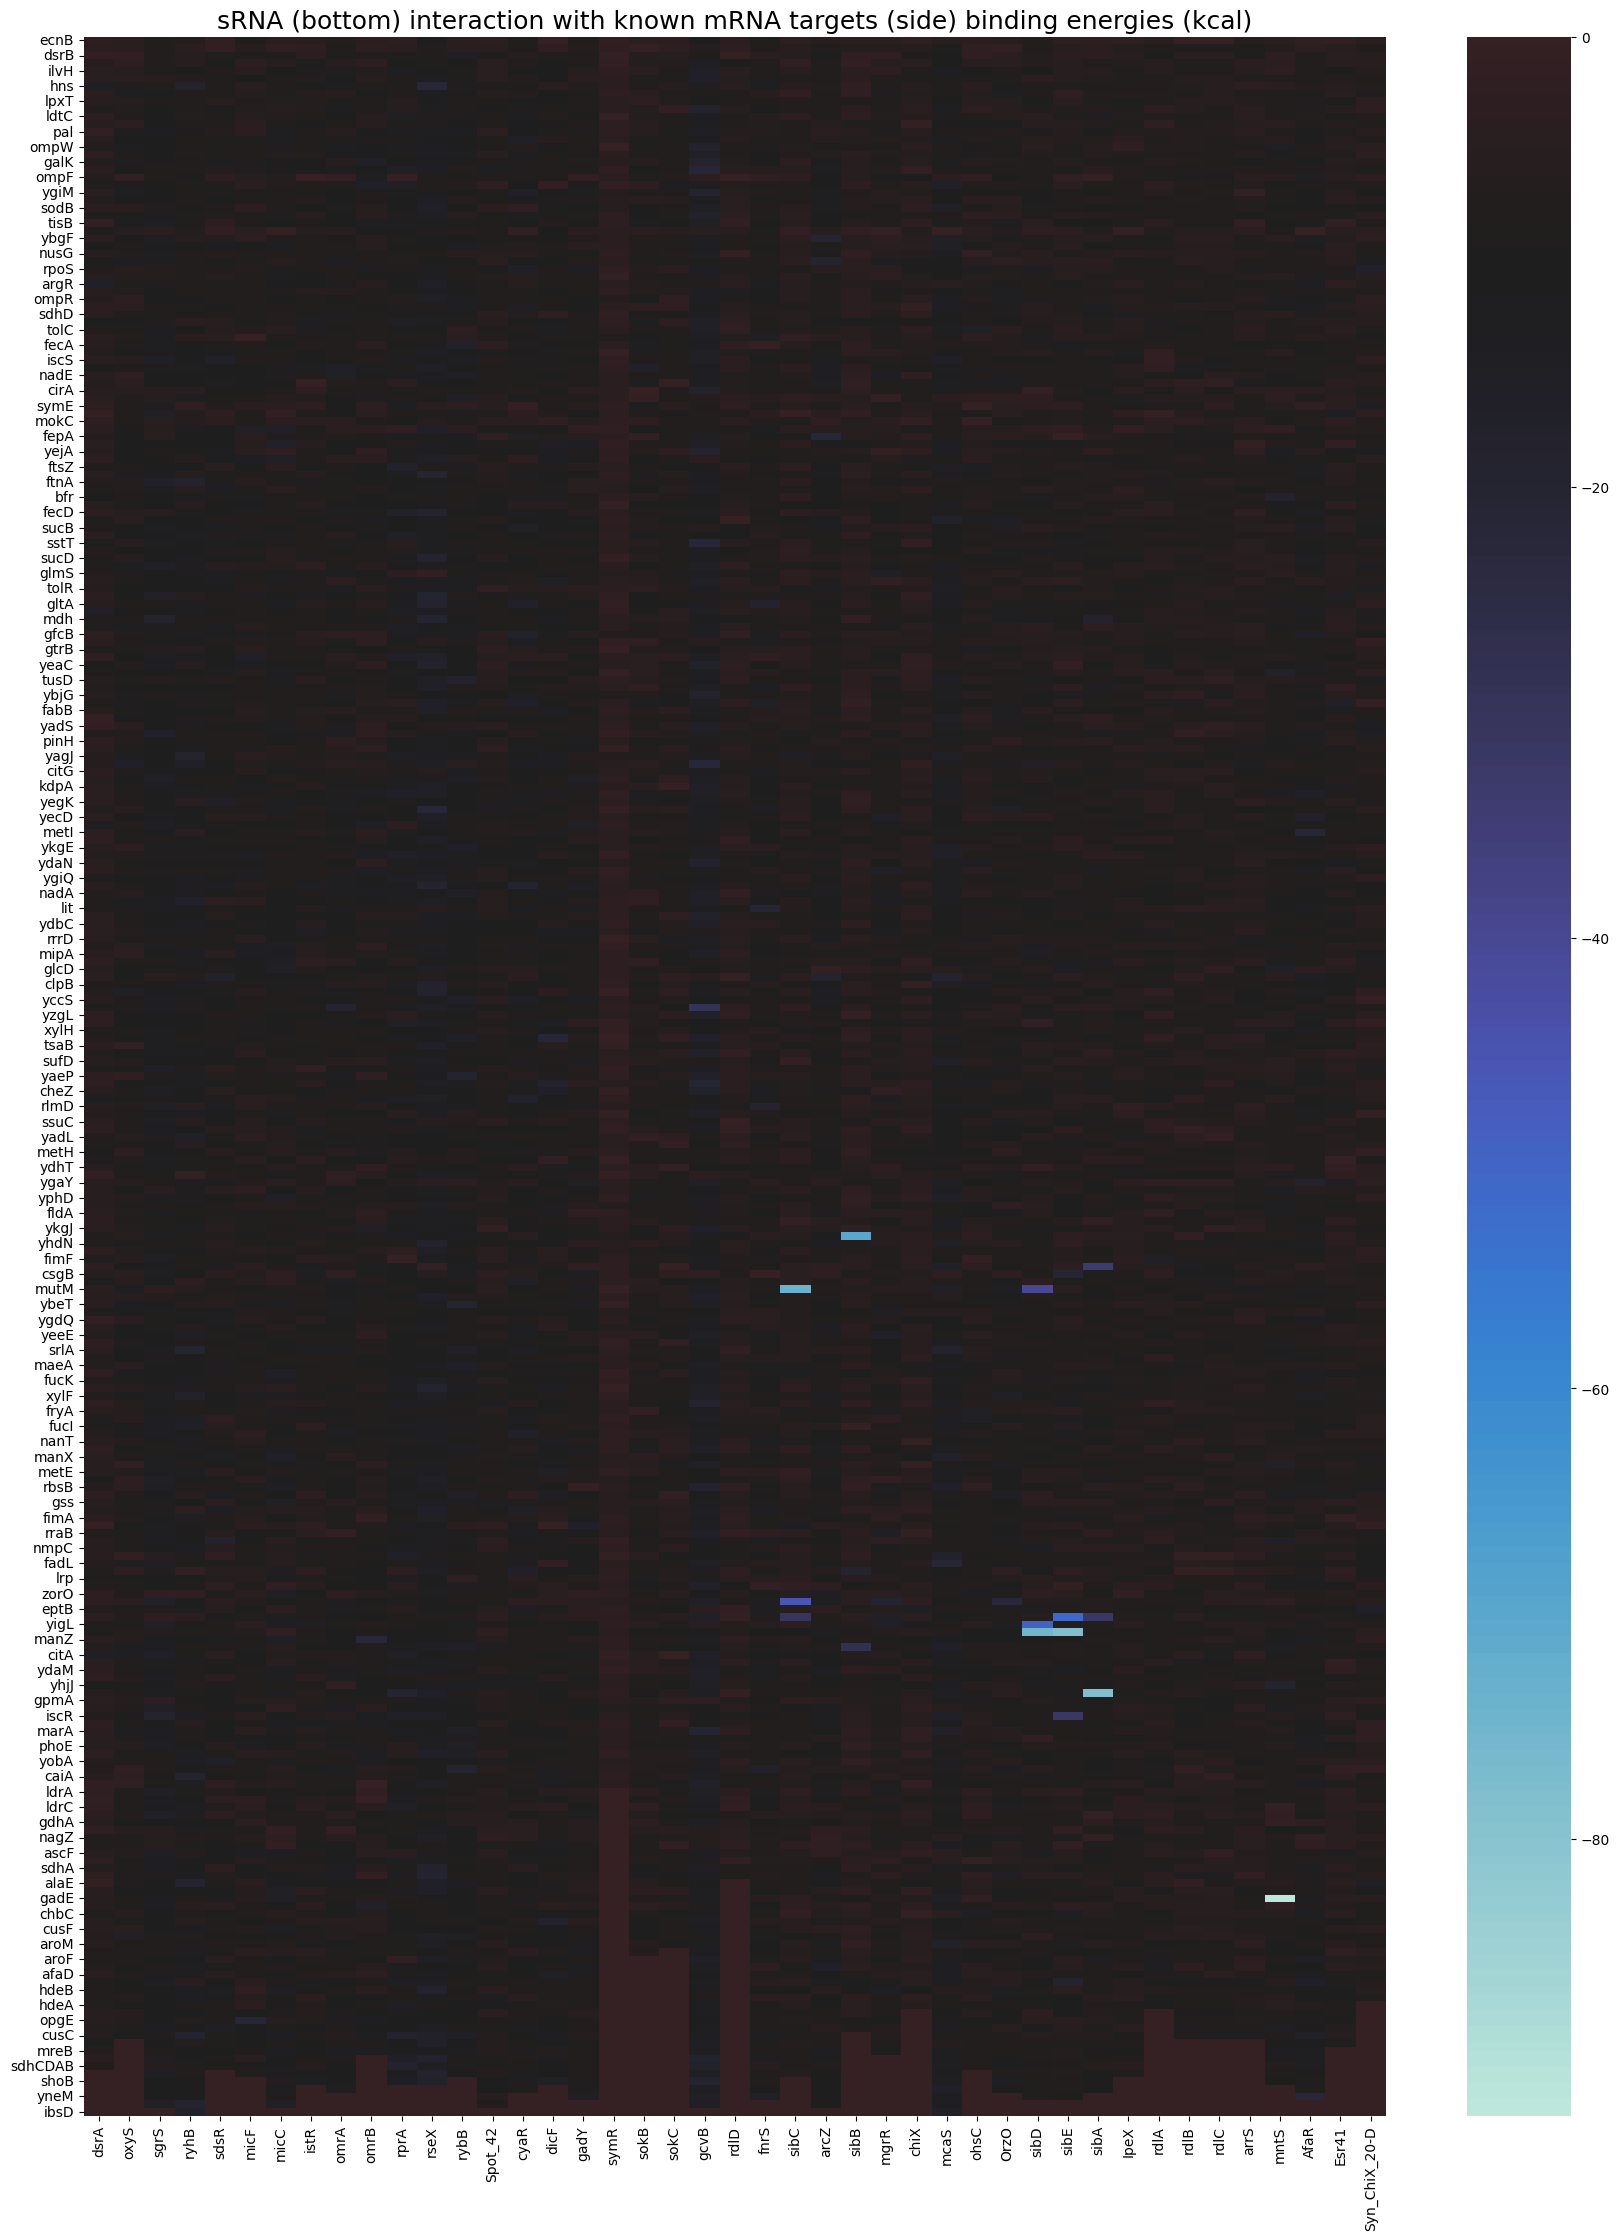

In [30]:
fig = plt.figure(figsize=(21, 27))
sns.heatmap(energies, center=-10, cmap= 'icefire') # Spectral, cubehelix, vlag
plt.title('sRNA (bottom) interaction with known mRNA targets (side) binding energies (kcal)', fontsize=18)

plt.savefig('data/figs/mRNA_official_energies.jpg')

### Energy norm cluster

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2400x2700 with 0 Axes>

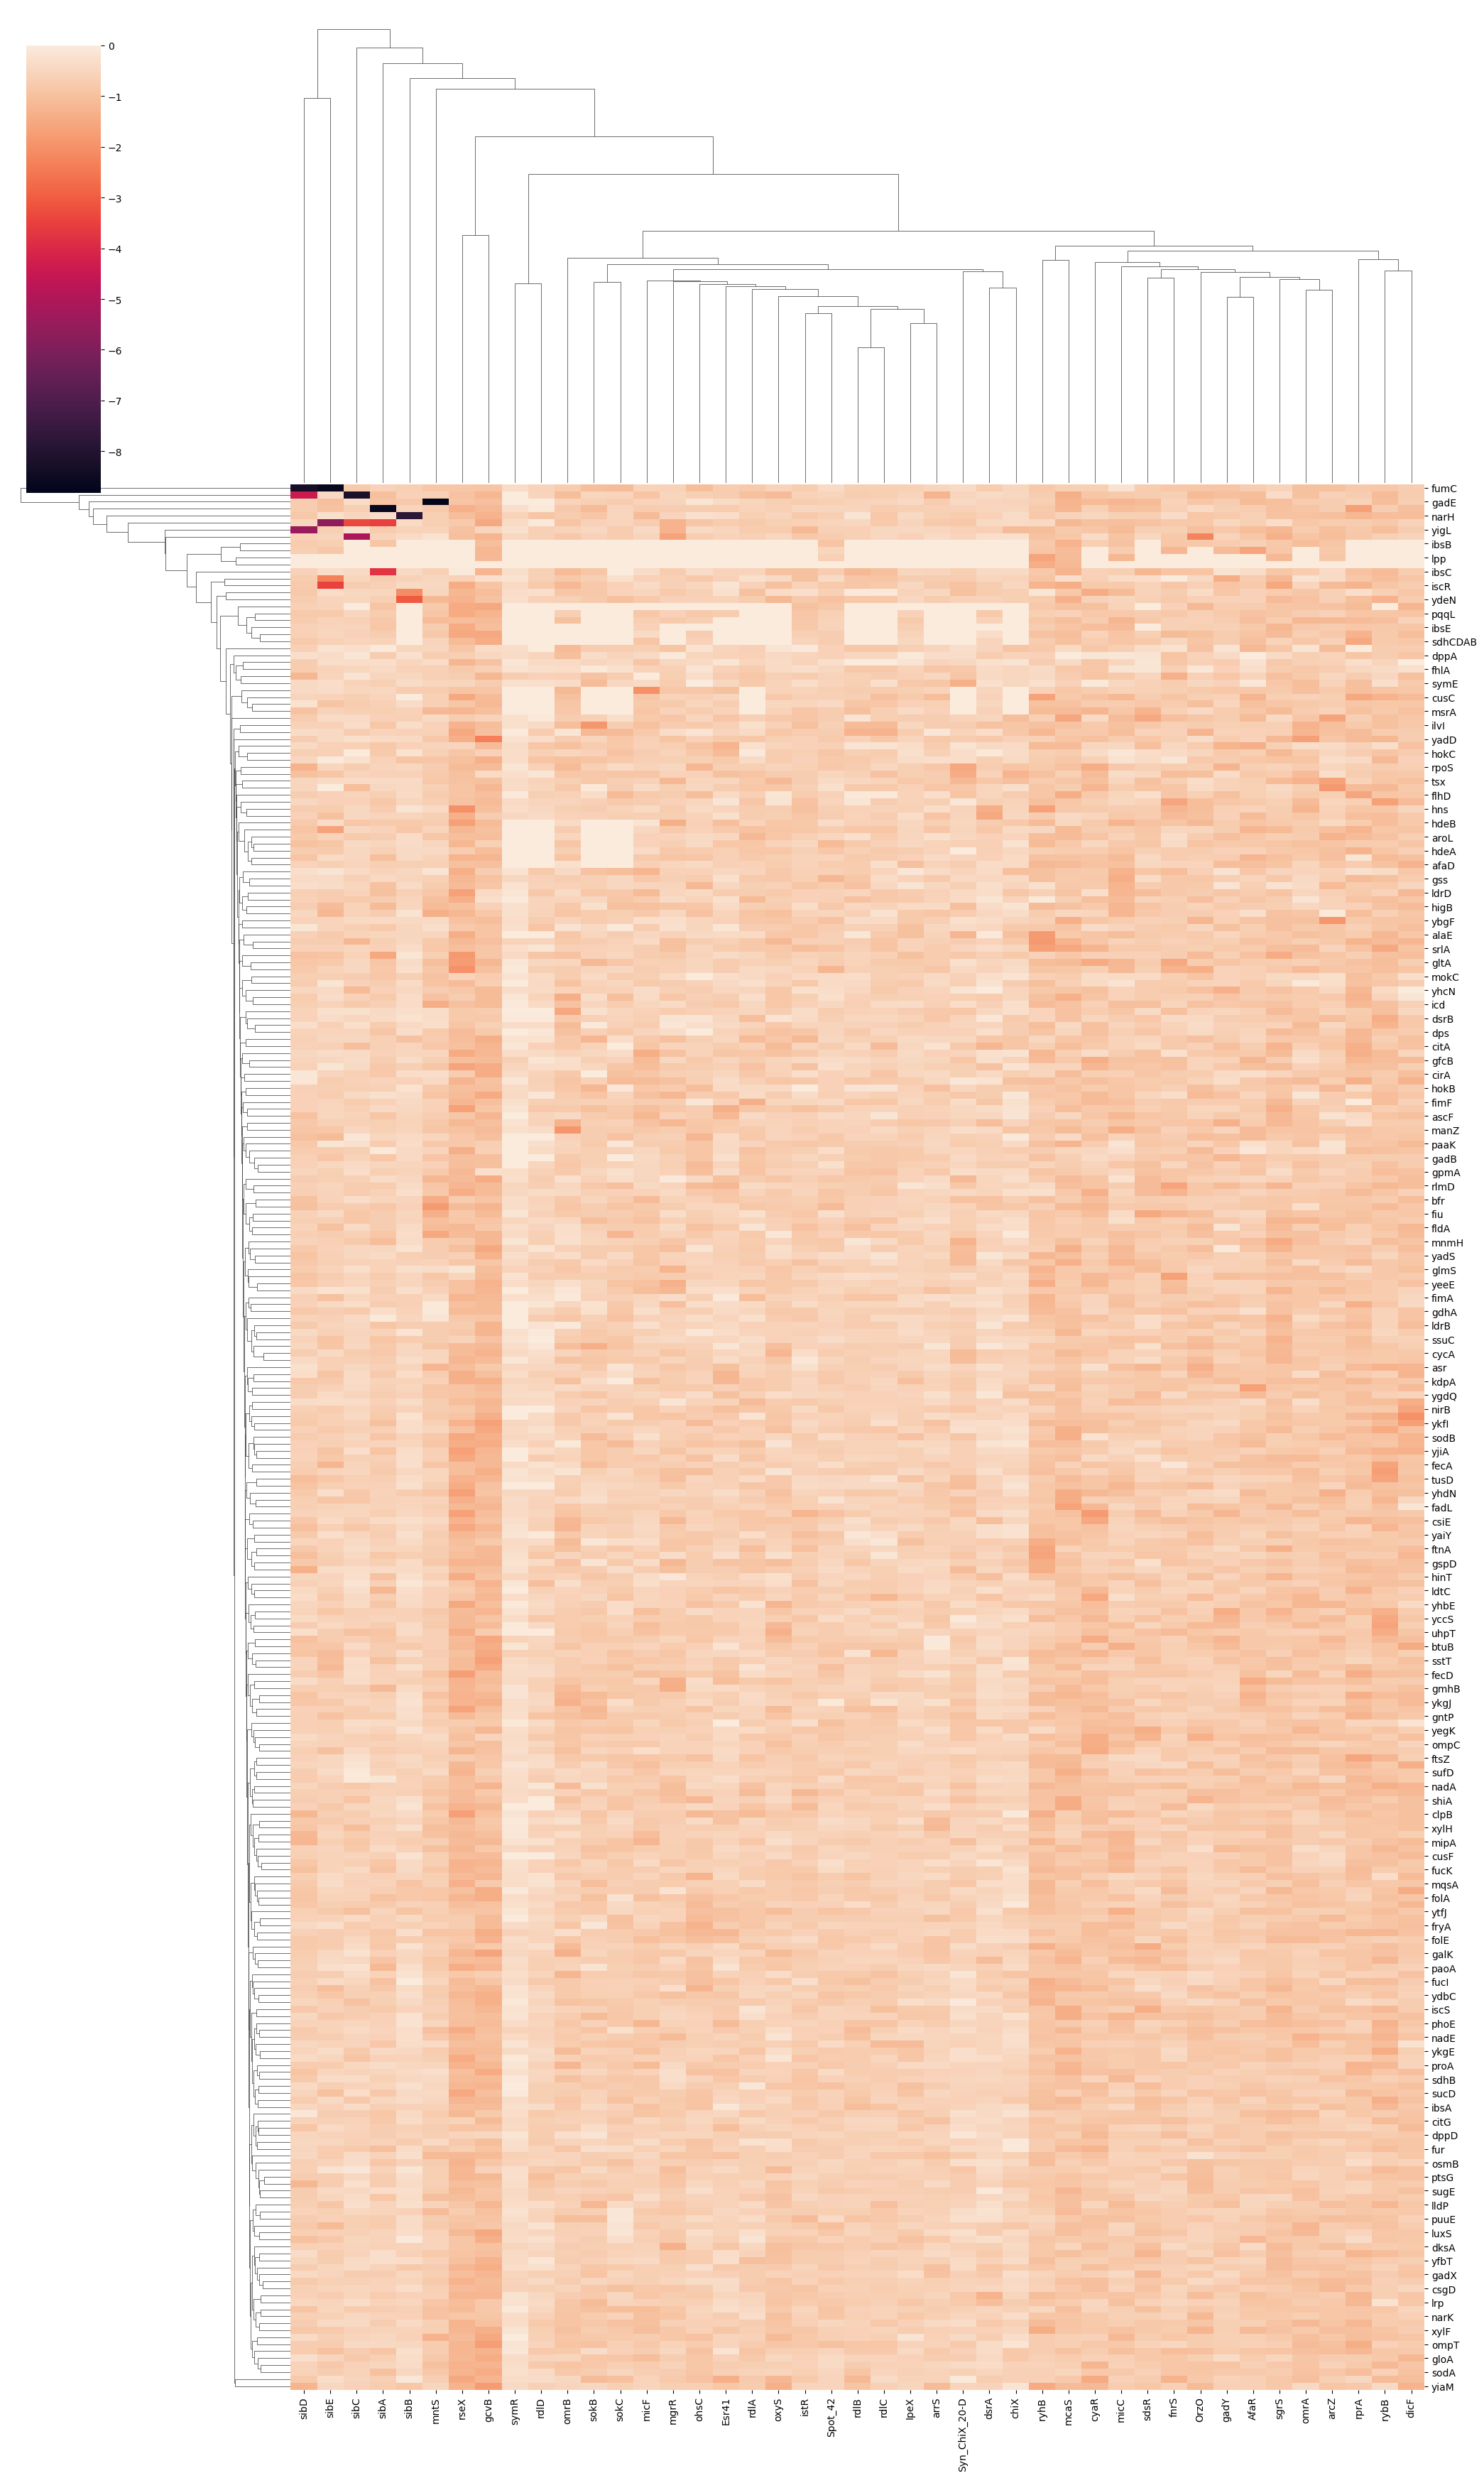

In [31]:
fig = plt.figure(figsize=(24, 27))
sns.clustermap(energies_norm, figsize=(21, 35)) #, cmap= 'icefire') # Spectral, cubehelix, vlag
# plt.title('sRNA (bottom) interaction with known mRNA targets (side) binding energies (kcal)')

plt.savefig('data/figs/mRNA_official_energies_norm_cluster.jpg')


### Energy norm heatmap

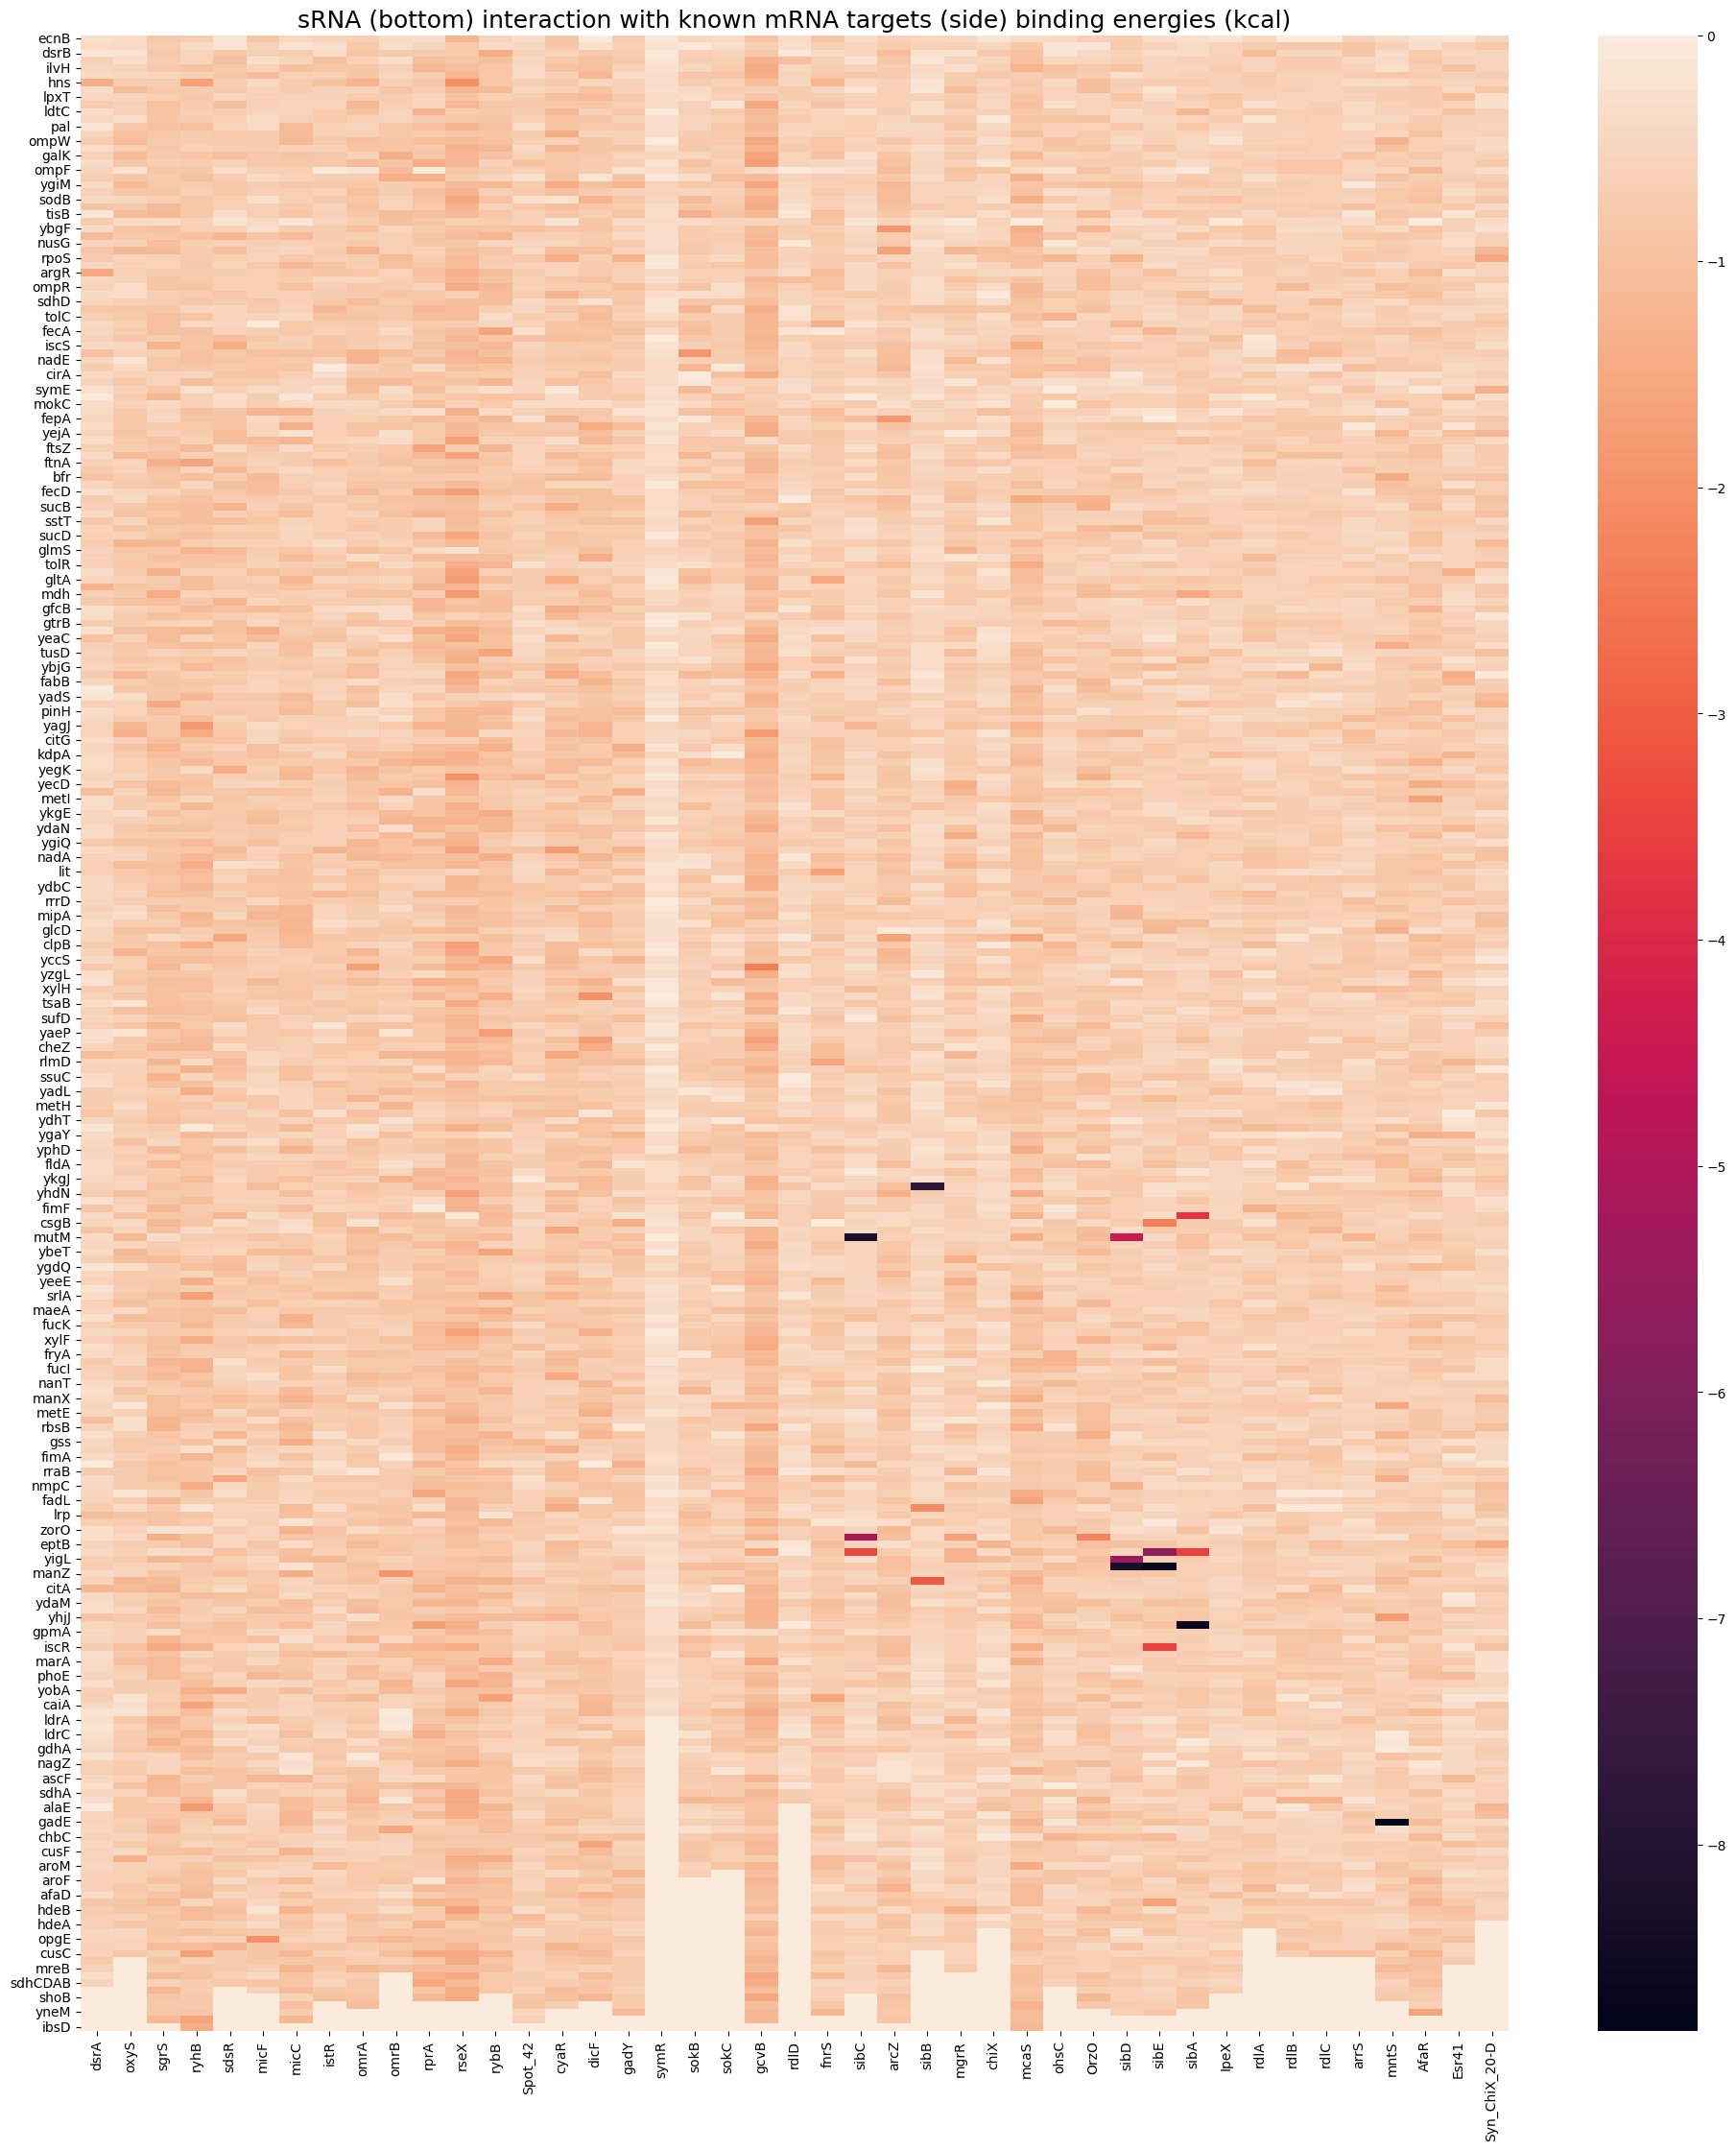

In [32]:
fig = plt.figure(figsize=(24, 27))
sns.heatmap(energies_norm) #, cmap= 'icefire') # Spectral, cubehelix, vlag
plt.title('sRNA (bottom) interaction with known mRNA targets (side) binding energies (kcal)', fontsize=18)

plt.savefig('data/figs/mRNA_official_energies_norm.jpg')


## Assess specificity

In [33]:
specificity = pd.DataFrame(data=np.zeros_like(np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l.values()]).T),
                           columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))

# for s in data[data['Category 1'] != 'mRNA']['Interactor 1'].unique():
#     specificity.loc[list(data[(data['Interactor 1'] == s) & (data['Category 2'] == 'mRNA') & (
#         ~data['Sequence 2'].isna())]['Interactor 2'].unique()), s] = 1
    
# for s in data[data['Category 2'] != 'mRNA']['Interactor 2'].unique():
#     specificity.loc[list(data[(data['Interactor 2'] == s) & (data['Category 1'] == 'mRNA') & (
#         ~data['Sequence 1'].isna())]['Interactor 1'].unique()), s] = 1
    
for s in srnas:
    specificity.loc[list(data[(data['Interactor 1'] == s) & (data['Category 2'] == 'mRNA') & (
        ~data['Sequence 2'].isna())]['Interactor 2'].unique()), s] = 1
    specificity.loc[list(data[(data['Interactor 2'] == s) & (data['Category 1'] == 'mRNA') & (
        ~data['Sequence 1'].isna())]['Interactor 1'].unique()), s] = 1

In [34]:
len(specificity.columns)

43

/tmp/ipykernel_3686744/3544752986.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


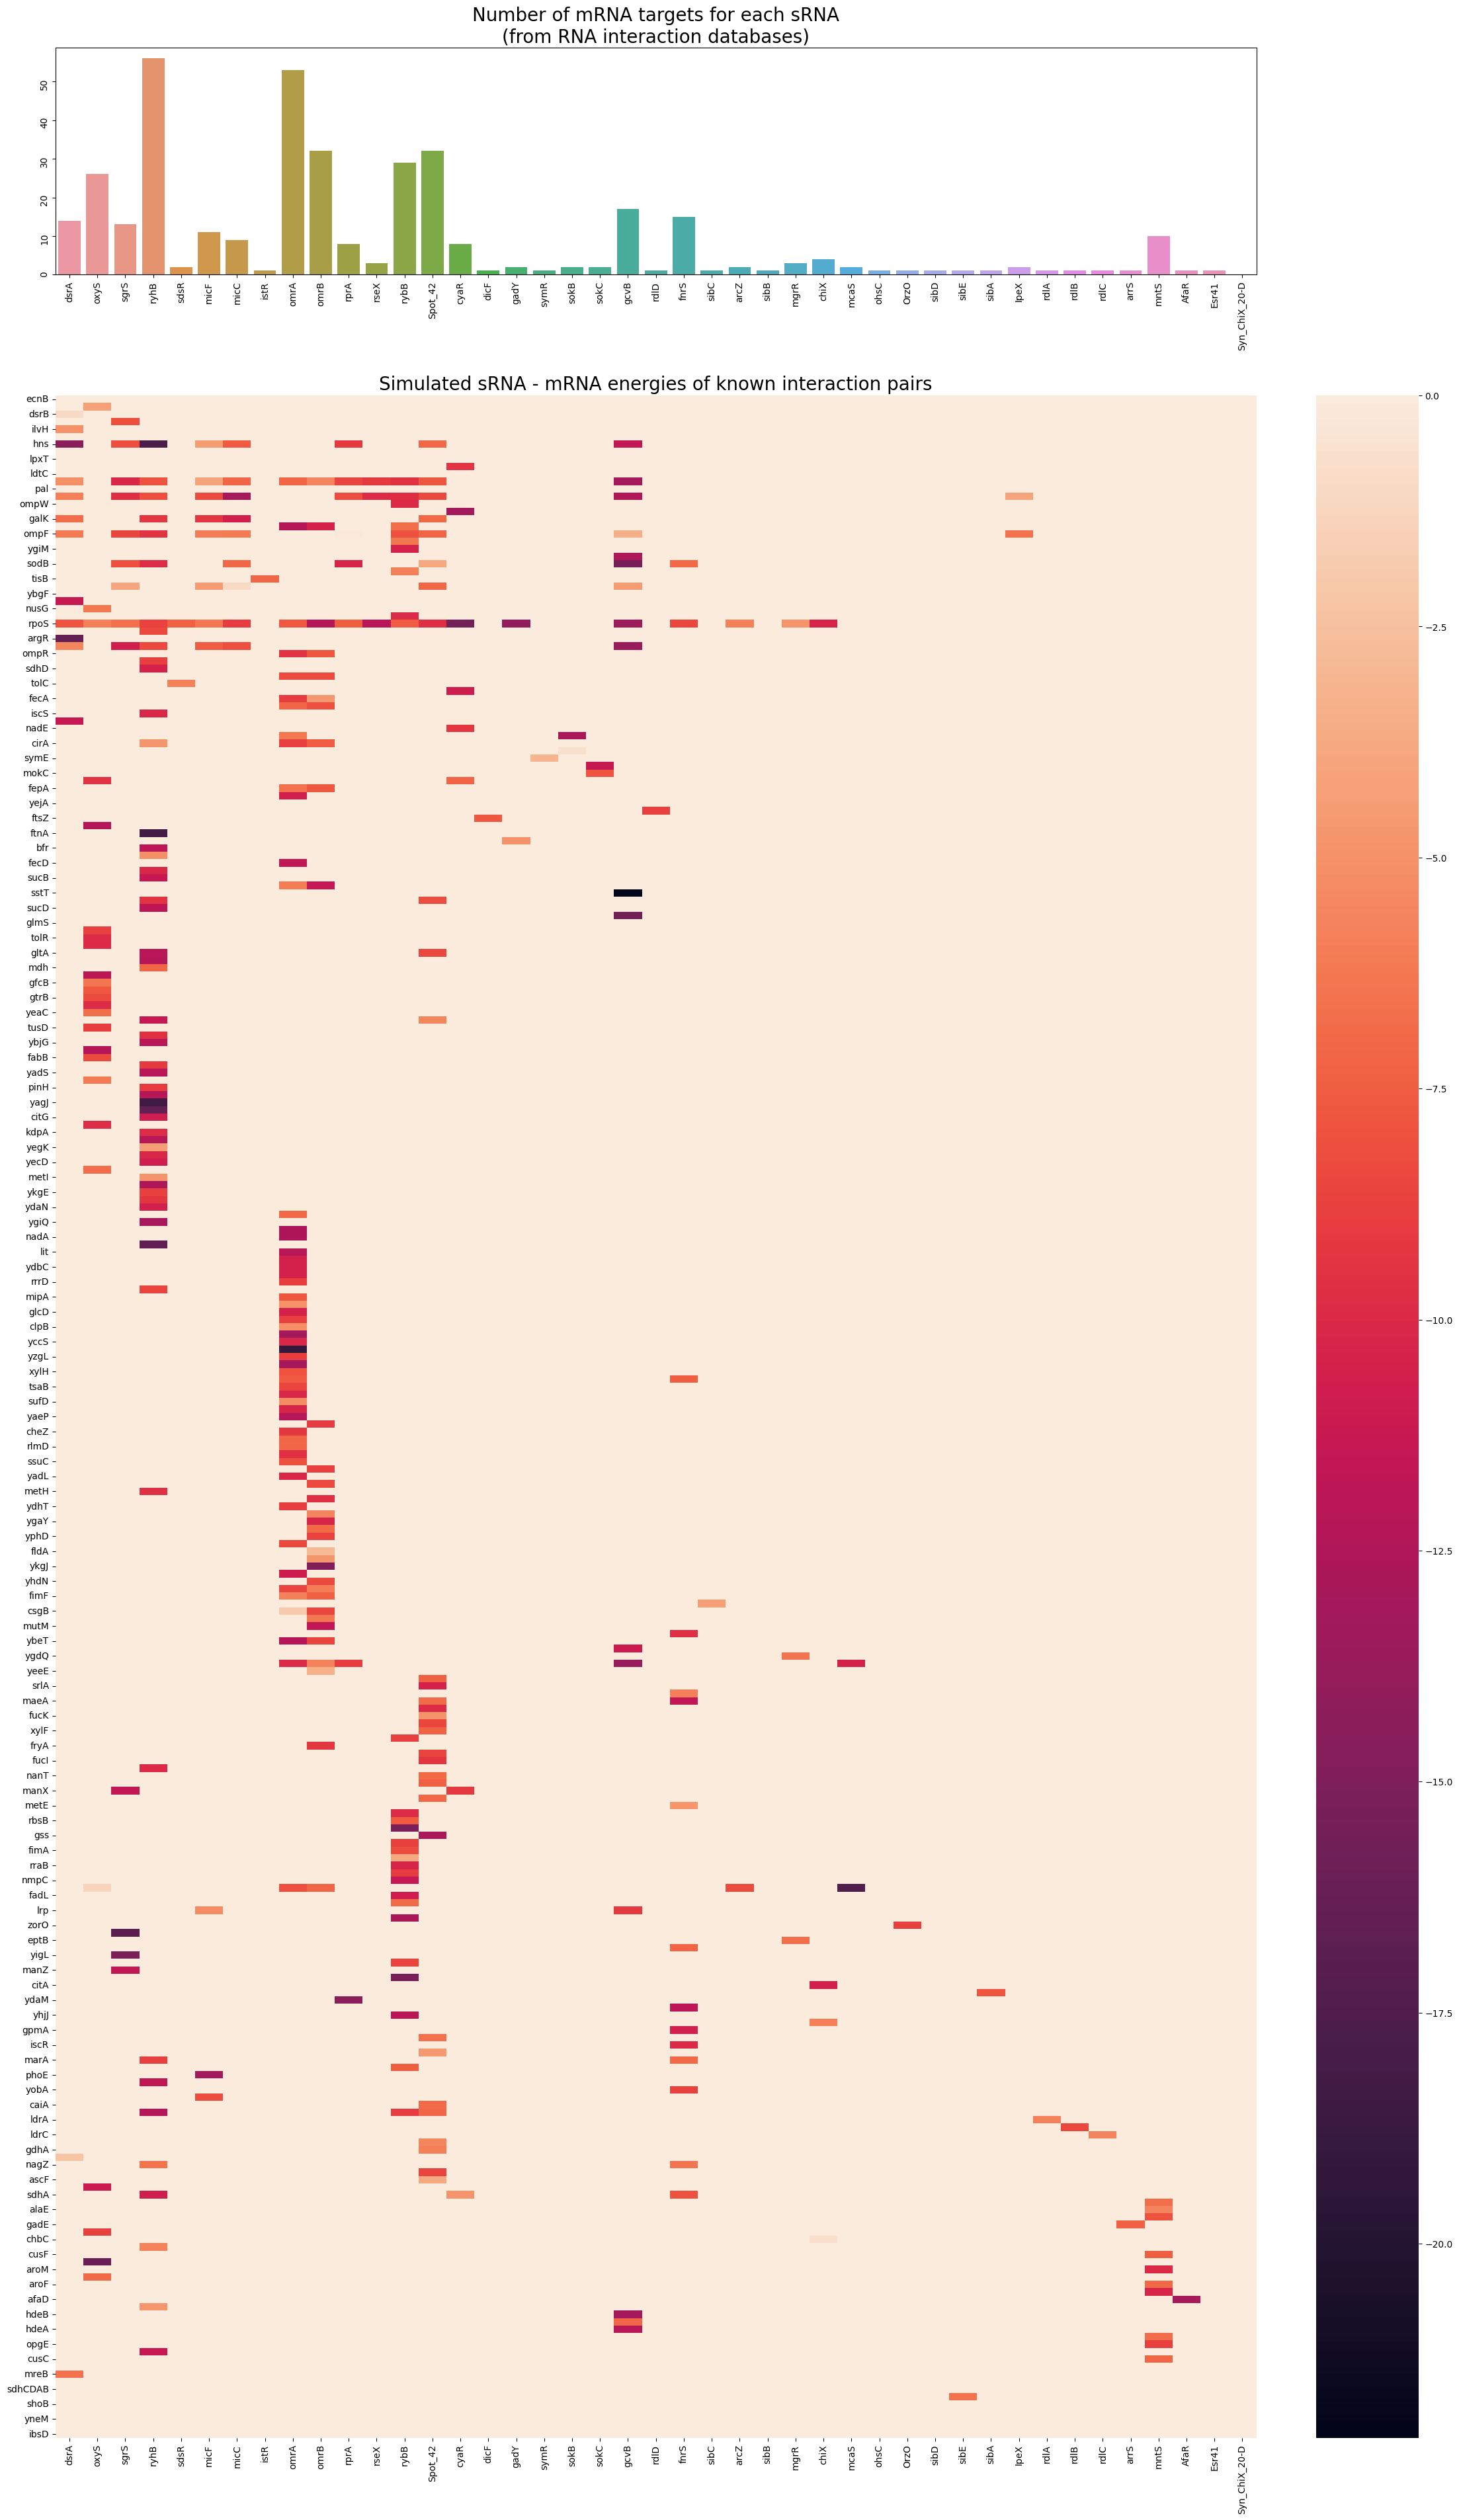

In [35]:
fig, axs = plt.subplots(2,1,figsize=(22, 38), gridspec_kw={'height_ratios': [1, 9]}, constrained_layout=True)
fig.subplots_adjust(hspace=0.5)

sns.barplot(x=specificity.columns, y=specificity.sum(axis=0), ax=axs[0]) #, order=[l.label1._text for l in cax.ax_heatmap.get_xaxis().majorTicks])
# sns.barplot(specificity.sum(axis=0), ax=axs[0]) #, order=[l.label1._text for l in cax.ax_heatmap.get_xaxis().majorTicks])
axs[0].tick_params(rotation=90) #, labelsize=7)
axs[0].set_title('Number of mRNA targets for each sRNA\n(from RNA interaction databases)', fontsize=20)


sns.heatmap(specificity * energies, ax=axs[1])
axs[1].set_title('Simulated sRNA - mRNA energies of known interaction pairs', fontsize=20)

plt.savefig('data/figs/mRNA_official_energies_known_pairs.jpg')


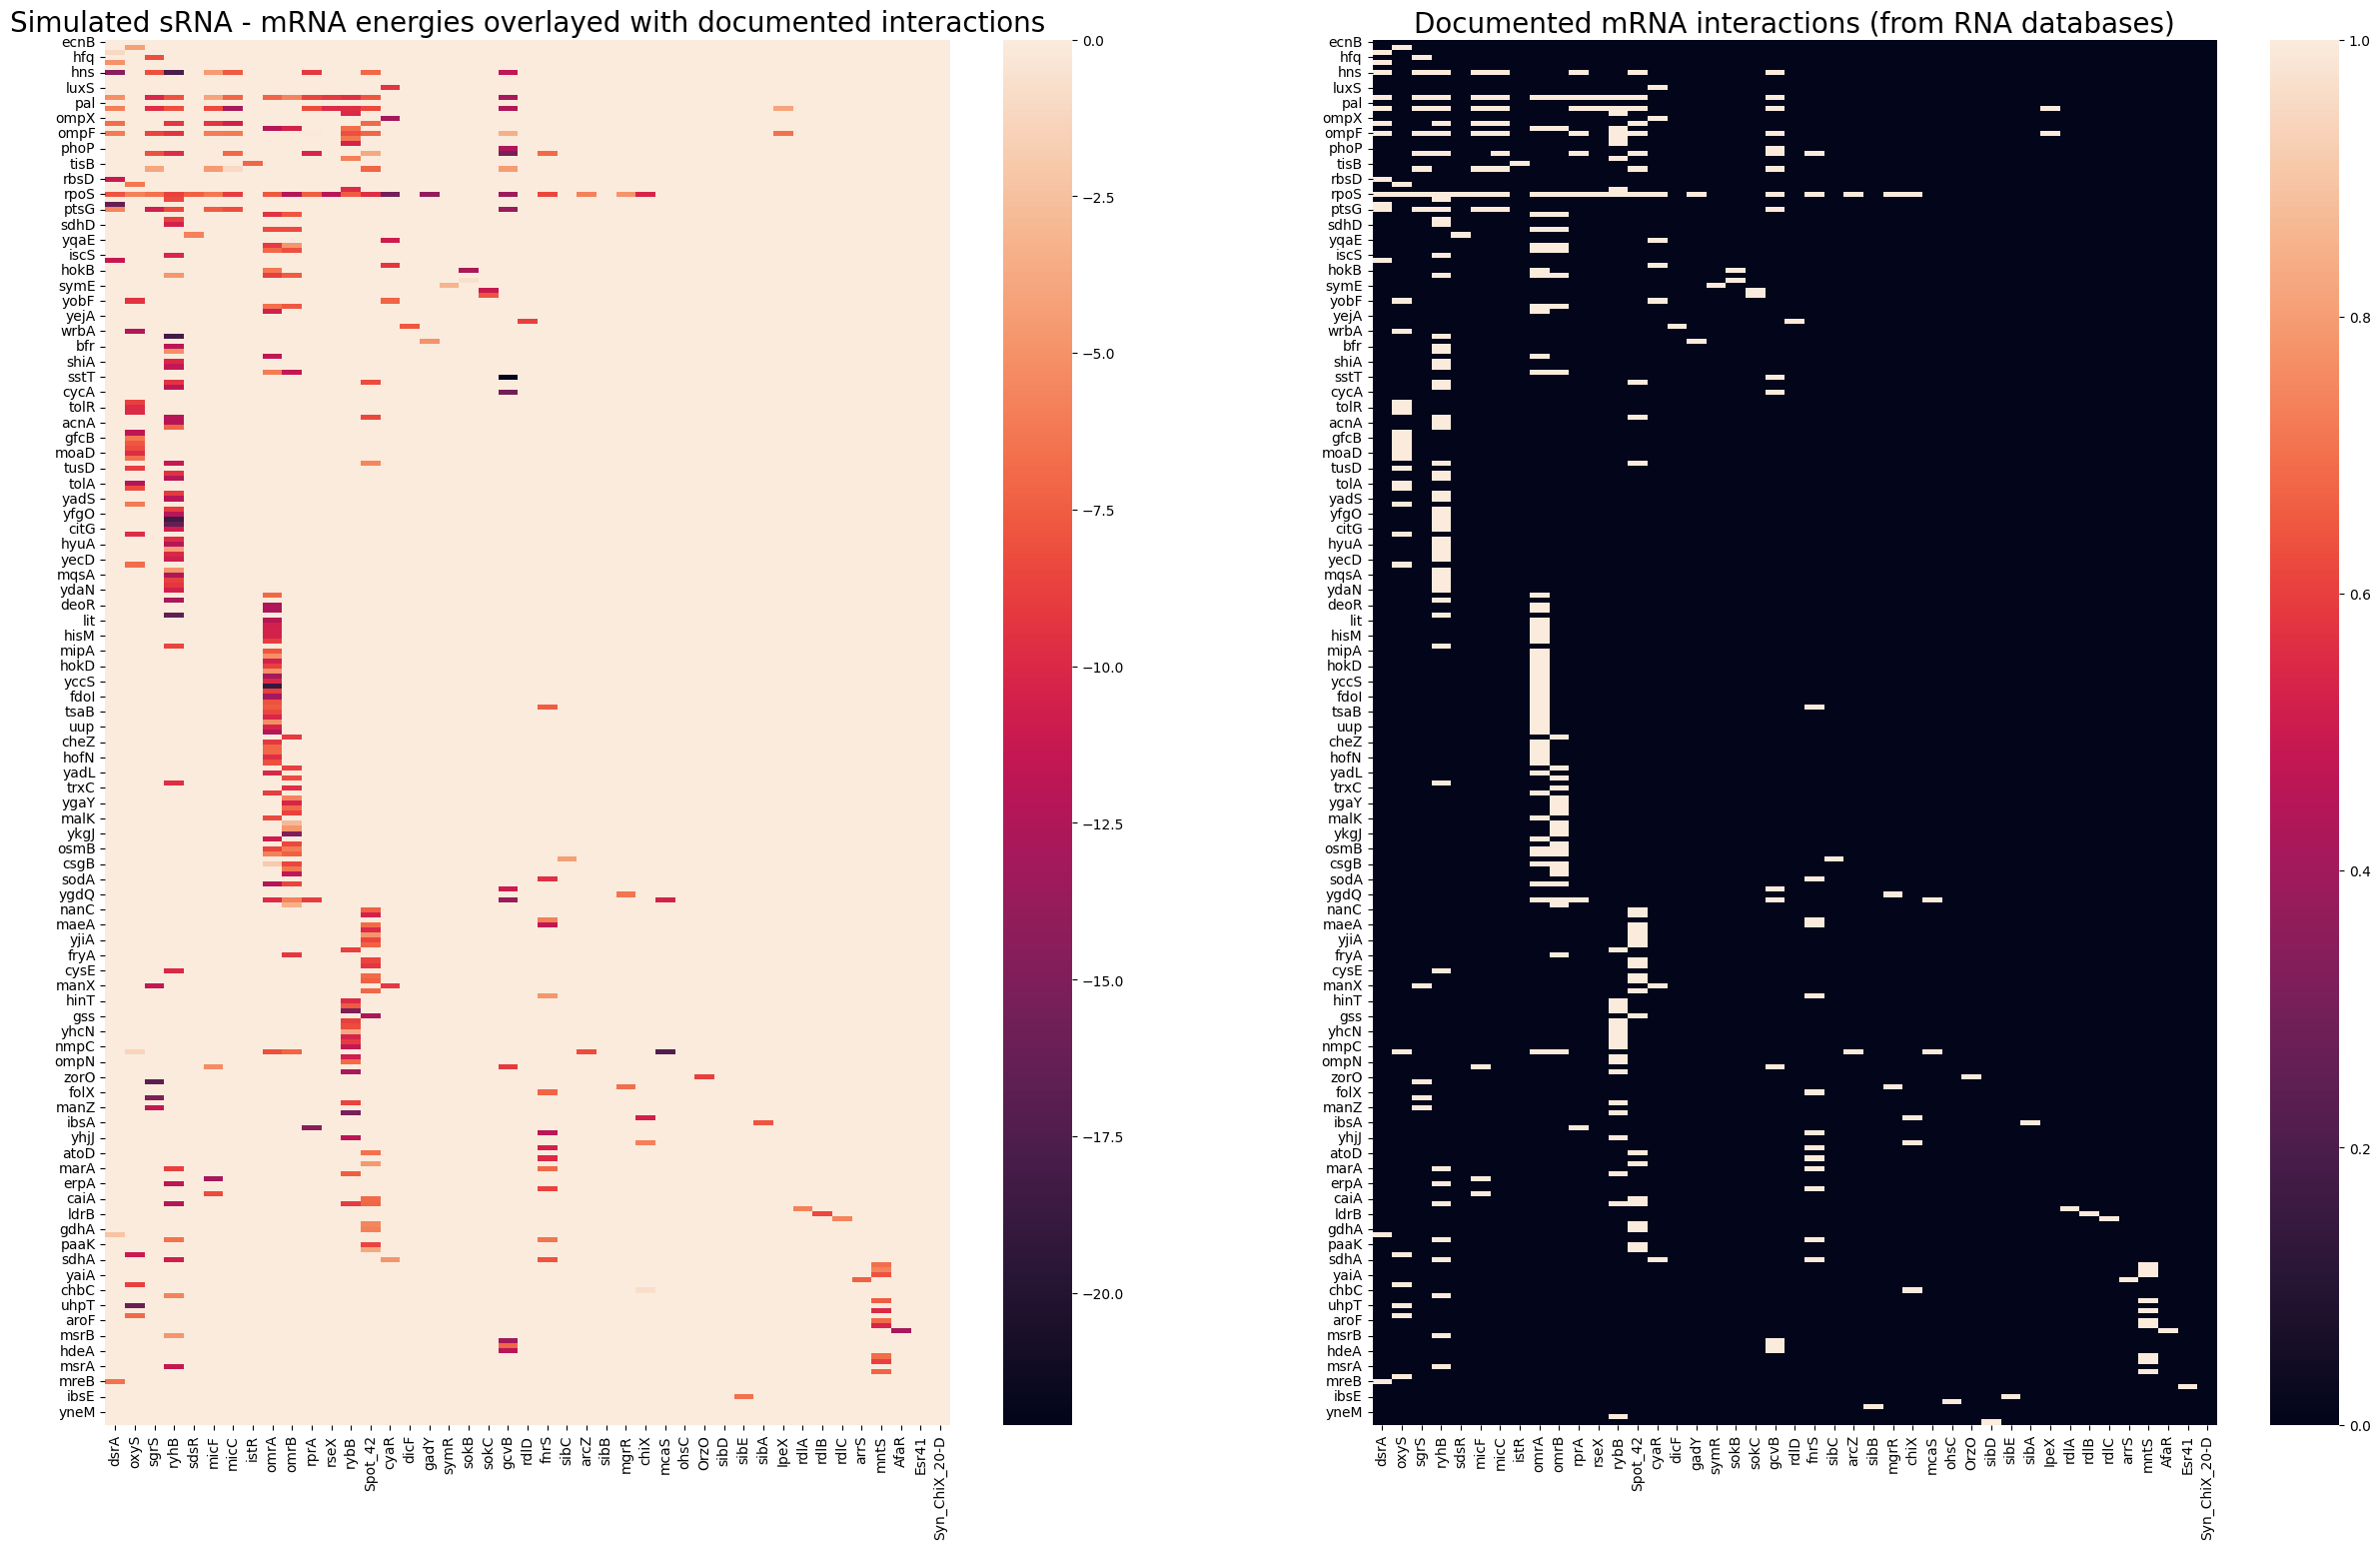

In [36]:
# threshold_binding_E = (specificity * energies).min(axis=0)
threshold_binding_E = np.where(specificity.sum(axis=0) > 0, (specificity * energies).max(axis=0), 0)

plt.figure(figsize=(30, 18))
ax = plt.subplot(1, 2, 1)
mask = (np.ones_like(energies) * (specificity.sum(axis=0) > 0).to_numpy()[None, :])
sns.heatmap(specificity * energies)
plt.title('Simulated sRNA - mRNA energies overlayed with documented interactions', fontsize=20)

ax = plt.subplot(1, 2, 2)
sns.heatmap(specificity)
plt.title('Documented mRNA interactions (from RNA databases)', fontsize=20)

plt.savefig('data/figs/mRNA_official_comparison.jpg')


In [37]:
# sns.scatterplot(x=(specificity * energies).sum(axis=0) / (np.where(specificity.sum(axis=0) == 0, 1, specificity.sum(axis=0))),
#                 y=energies.sum(axis=0) / (energies < 0).sum(axis=0))

# plt.xlabel('Average binding energy of documented interactions per sRNA')
# plt.ylabel('Average binding energy for all mRNAs per sRNA')
# plt.title('')

In [38]:
specificity_missing_cols = [c for c in specificity.columns if c not in energies.columns]
print('Not including the following documented interaction targets likely due to missing sequence:',
      specificity_missing_cols)
specificity = specificity.drop(columns=specificity_missing_cols)

Not including the following documented interaction targets likely due to missing sequence: []


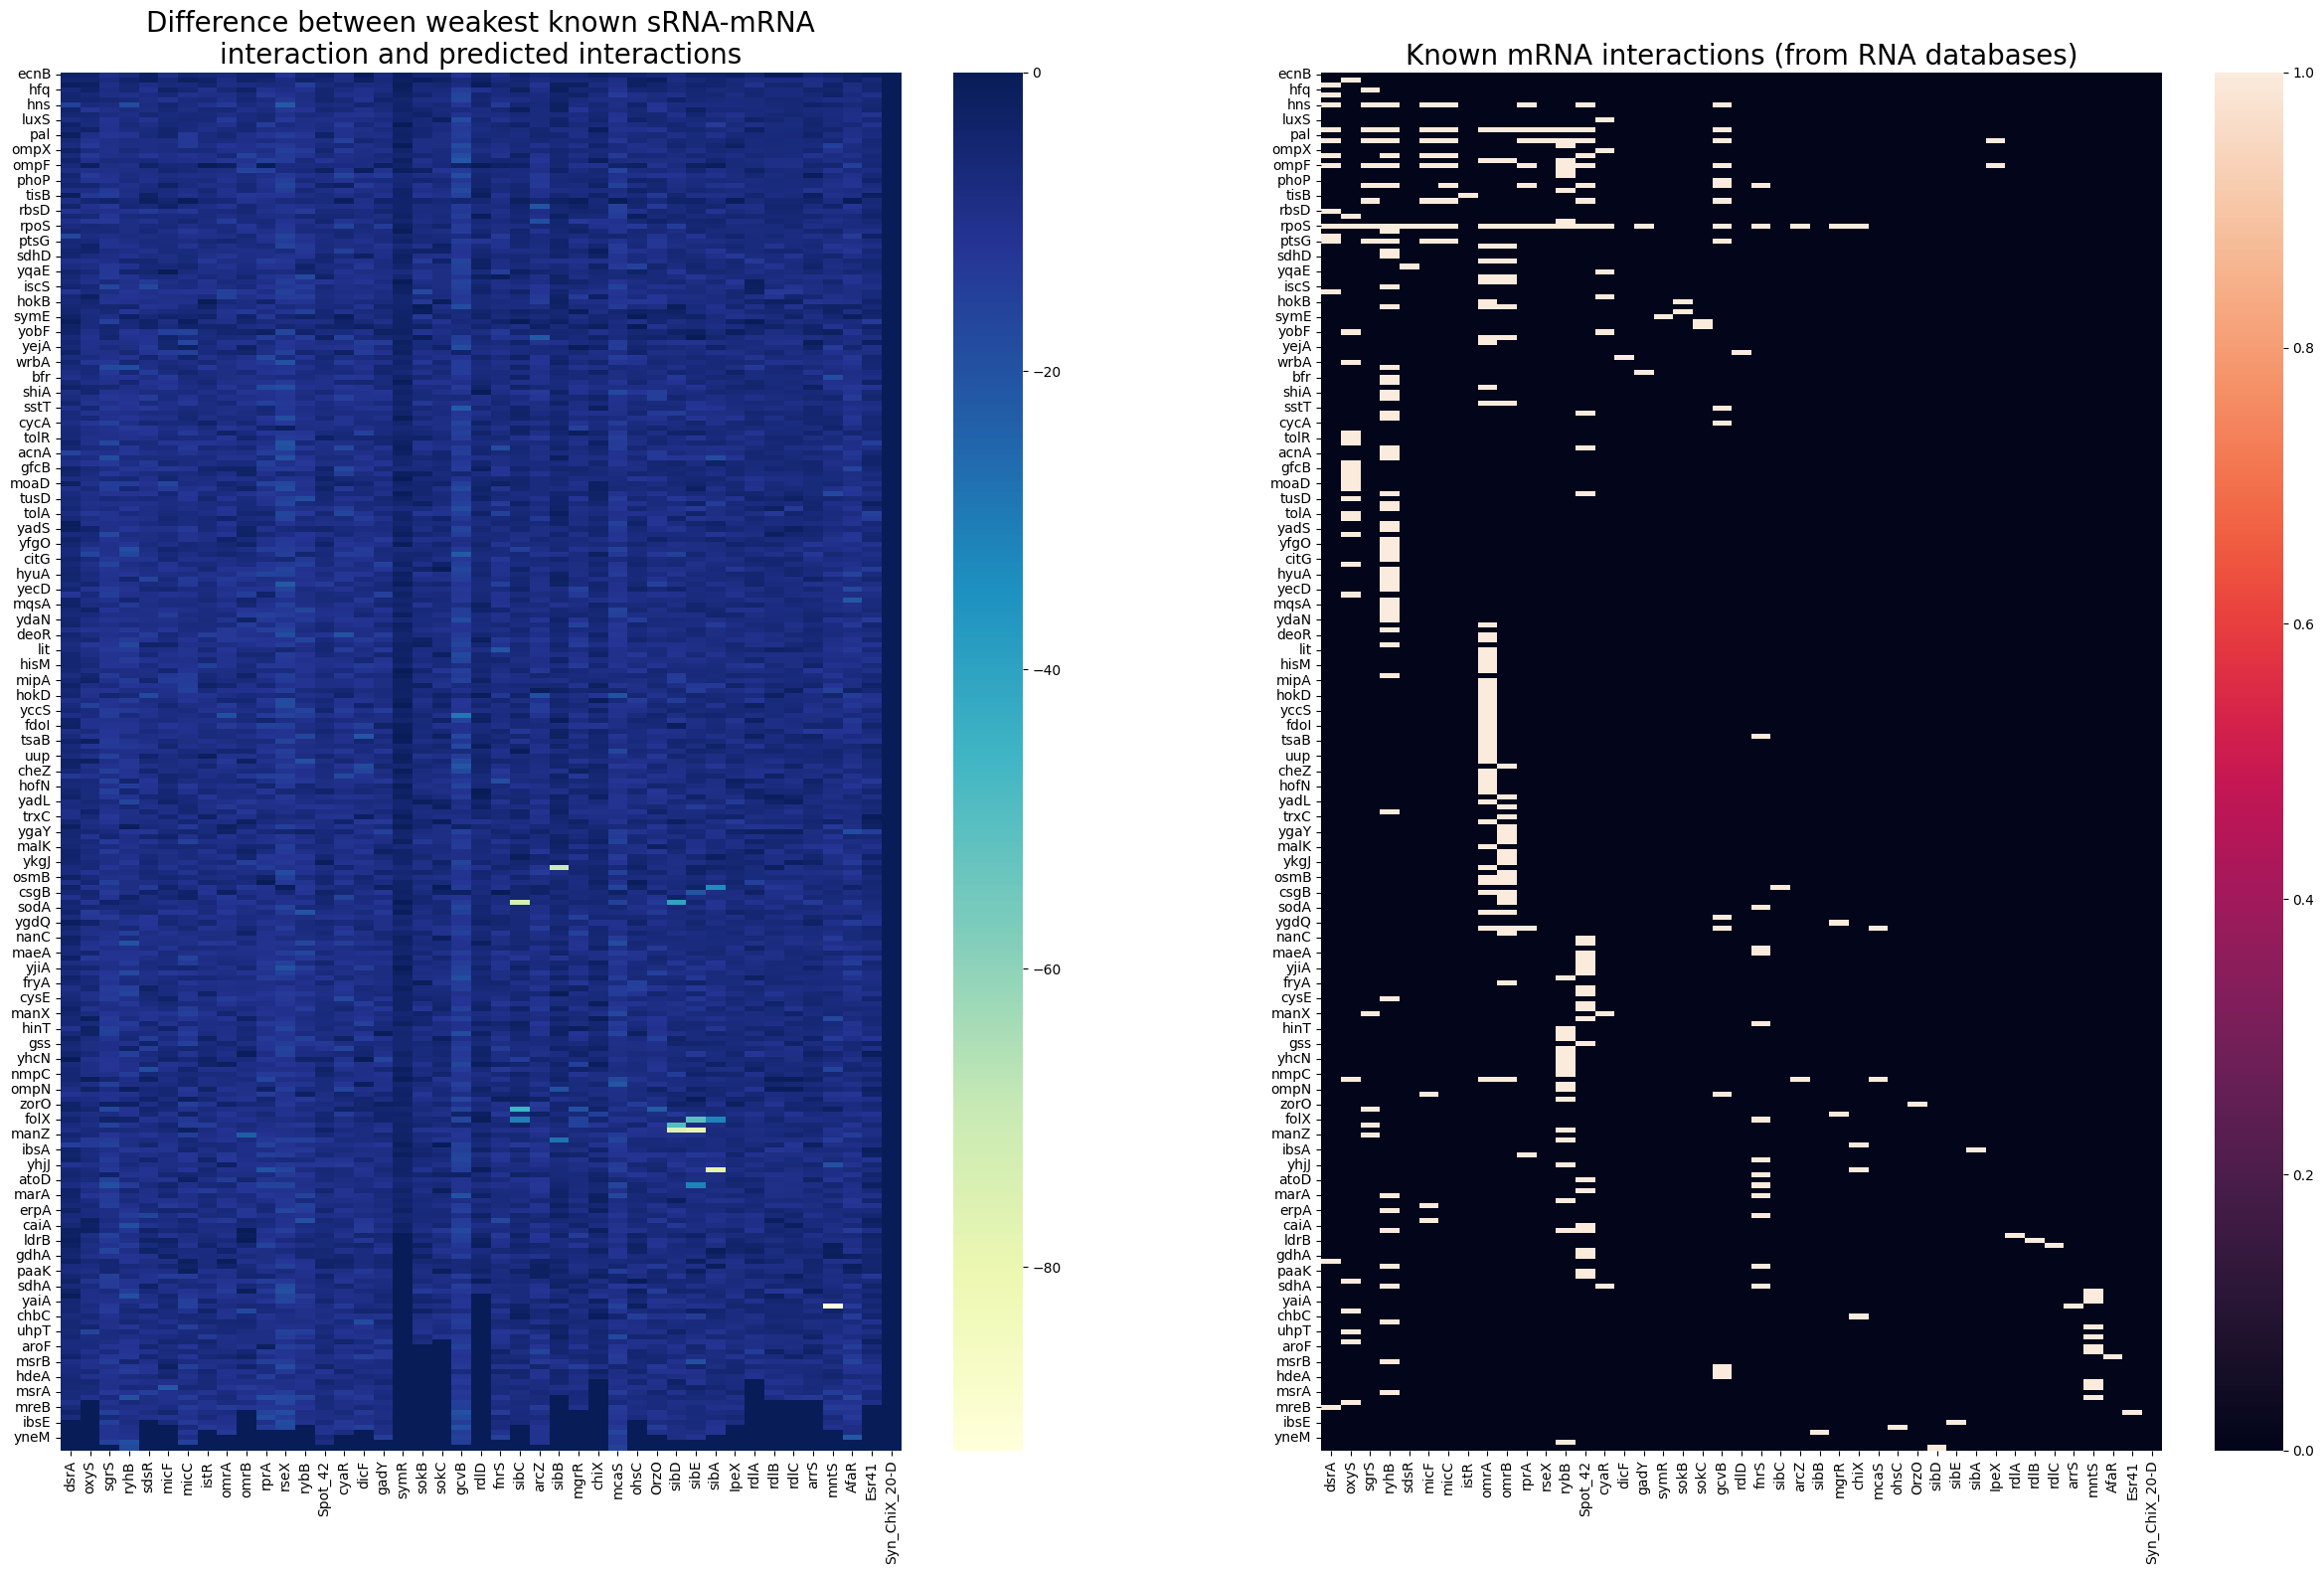

In [39]:
# threshold_binding_E = (specificity * energies).min(axis=0)
threshold_binding_E = np.where(specificity.sum(axis=0) > 0, (specificity * energies).max(axis=0), 0)

plt.figure(figsize=(30, 18))
ax = plt.subplot(1, 2, 1)
mask = (np.ones_like(energies) * (specificity.sum(axis=0) > 0).to_numpy()[None, :])
sns.heatmap(energies * mask - (
    np.ones_like(energies) * threshold_binding_E[None, :]), cmap='YlGnBu')
plt.title('Difference between weakest known sRNA-mRNA\ninteraction and predicted interactions', fontsize=20)

ax = plt.subplot(1, 2, 2)
sns.heatmap(specificity)
plt.title('Known mRNA interactions (from RNA databases)', fontsize=20)

plt.savefig('data/figs/mRNA_official_energies_known_pairs_weakestE.jpg')


## Look at binding probability

In [40]:
pus1 = pd.DataFrame(data=np.array([[float(vv['Pu1']) for vv in v.values()] for v in sim_data_l.values()]).T,
                    columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))
pus2 = pd.DataFrame(data=np.array([[float(vv['Pu2']) for vv in v.values()] for v in sim_data_l.values()]).T,
                    columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))
subseq = pd.DataFrame(data=np.array([[len(vv['subseqDB'].split('&')[0]) - 1 if len(vv['subseqDB'].split('&')[0]) > 0 else 0 for vv in v.values()] for v in sim_data_l.values()]).T,
                      columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))

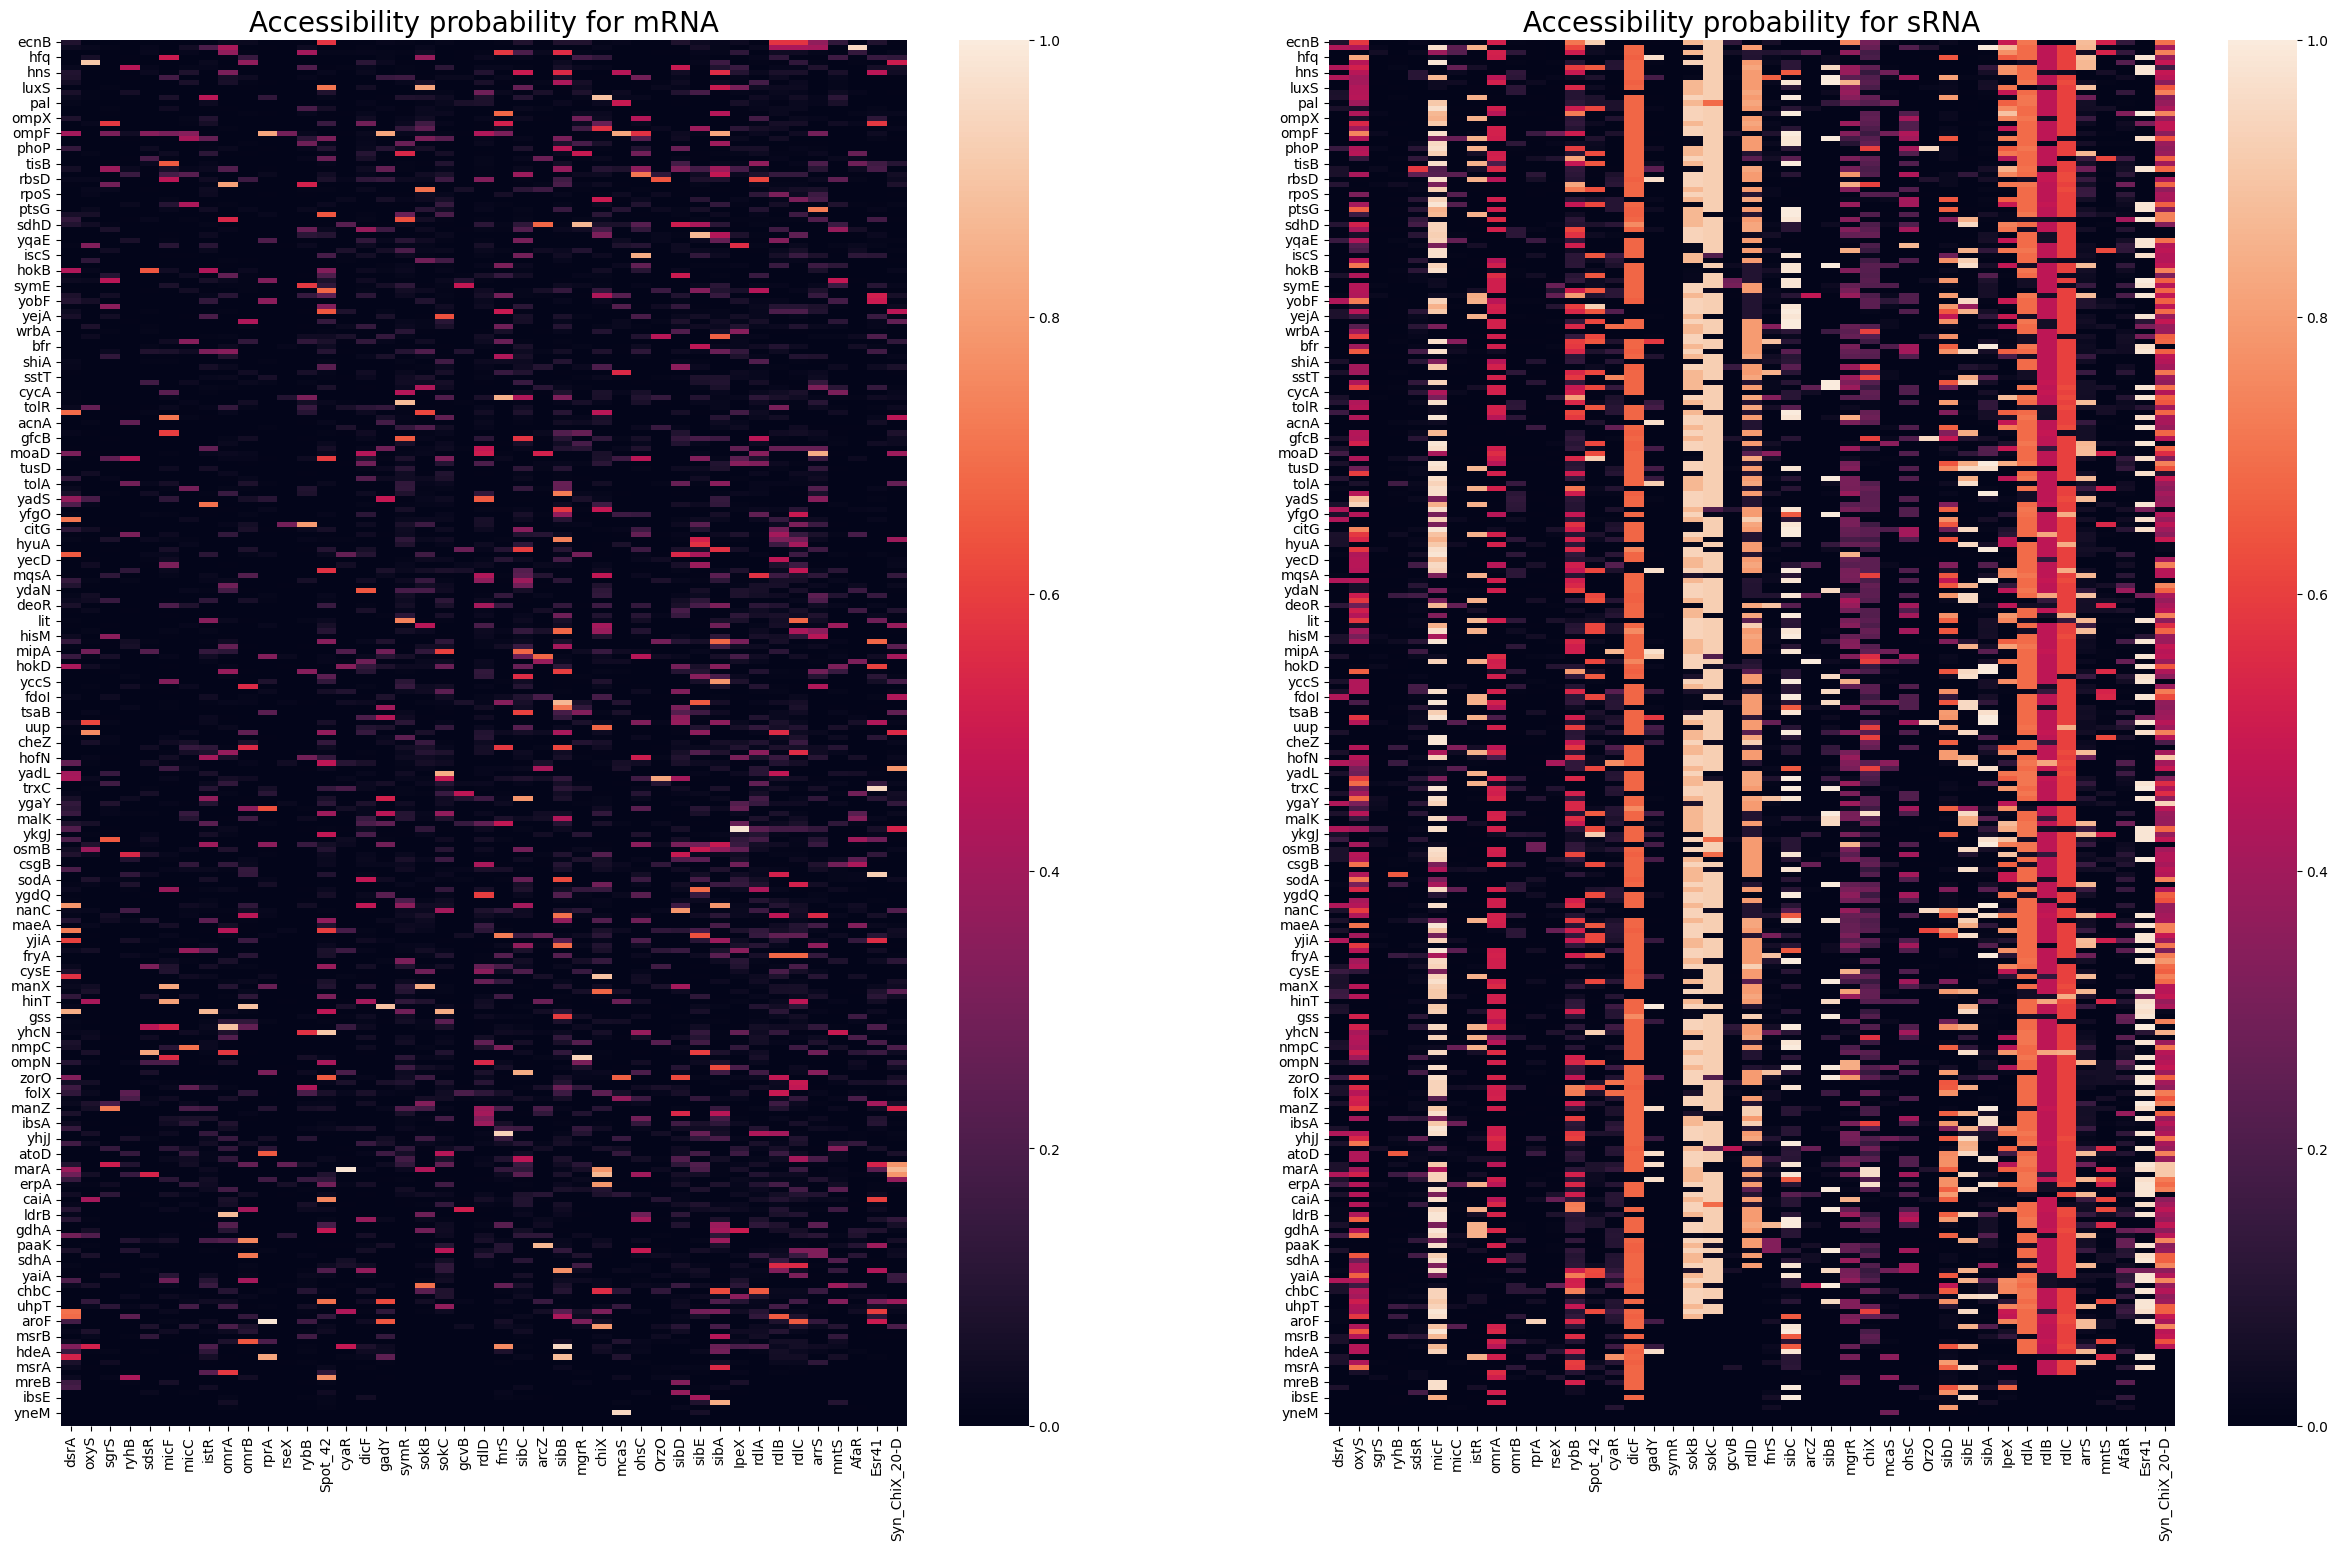

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(30, 18))

# ax = plt.subplot(1,2,1)
sns.heatmap(pus1, ax=axs[0], vmin=np.min([pus1.min(), pus2.min()]), vmax=np.max([pus1.max(), pus2.max()])) #, order=[l.label1._text for l in cax.ax_heatmap.get_xaxis().majorTicks])
# axs[0].tick_params(rotation=90) #, labelsize=7)
axs[0].set_title('Accessibility probability for mRNA', fontsize=20)

ax = plt.subplot(1,2,2)
sns.heatmap(pus2, ax=axs[1], vmin=np.min([pus1.min(), pus2.min()]), vmax=np.max([pus1.max(), pus2.max()]))
axs[1].set_title('Accessibility probability for sRNA', fontsize=20)

plt.savefig('data/figs/mRNA_official_accessibility.jpg')


/tmp/ipykernel_3686744/2637676918.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


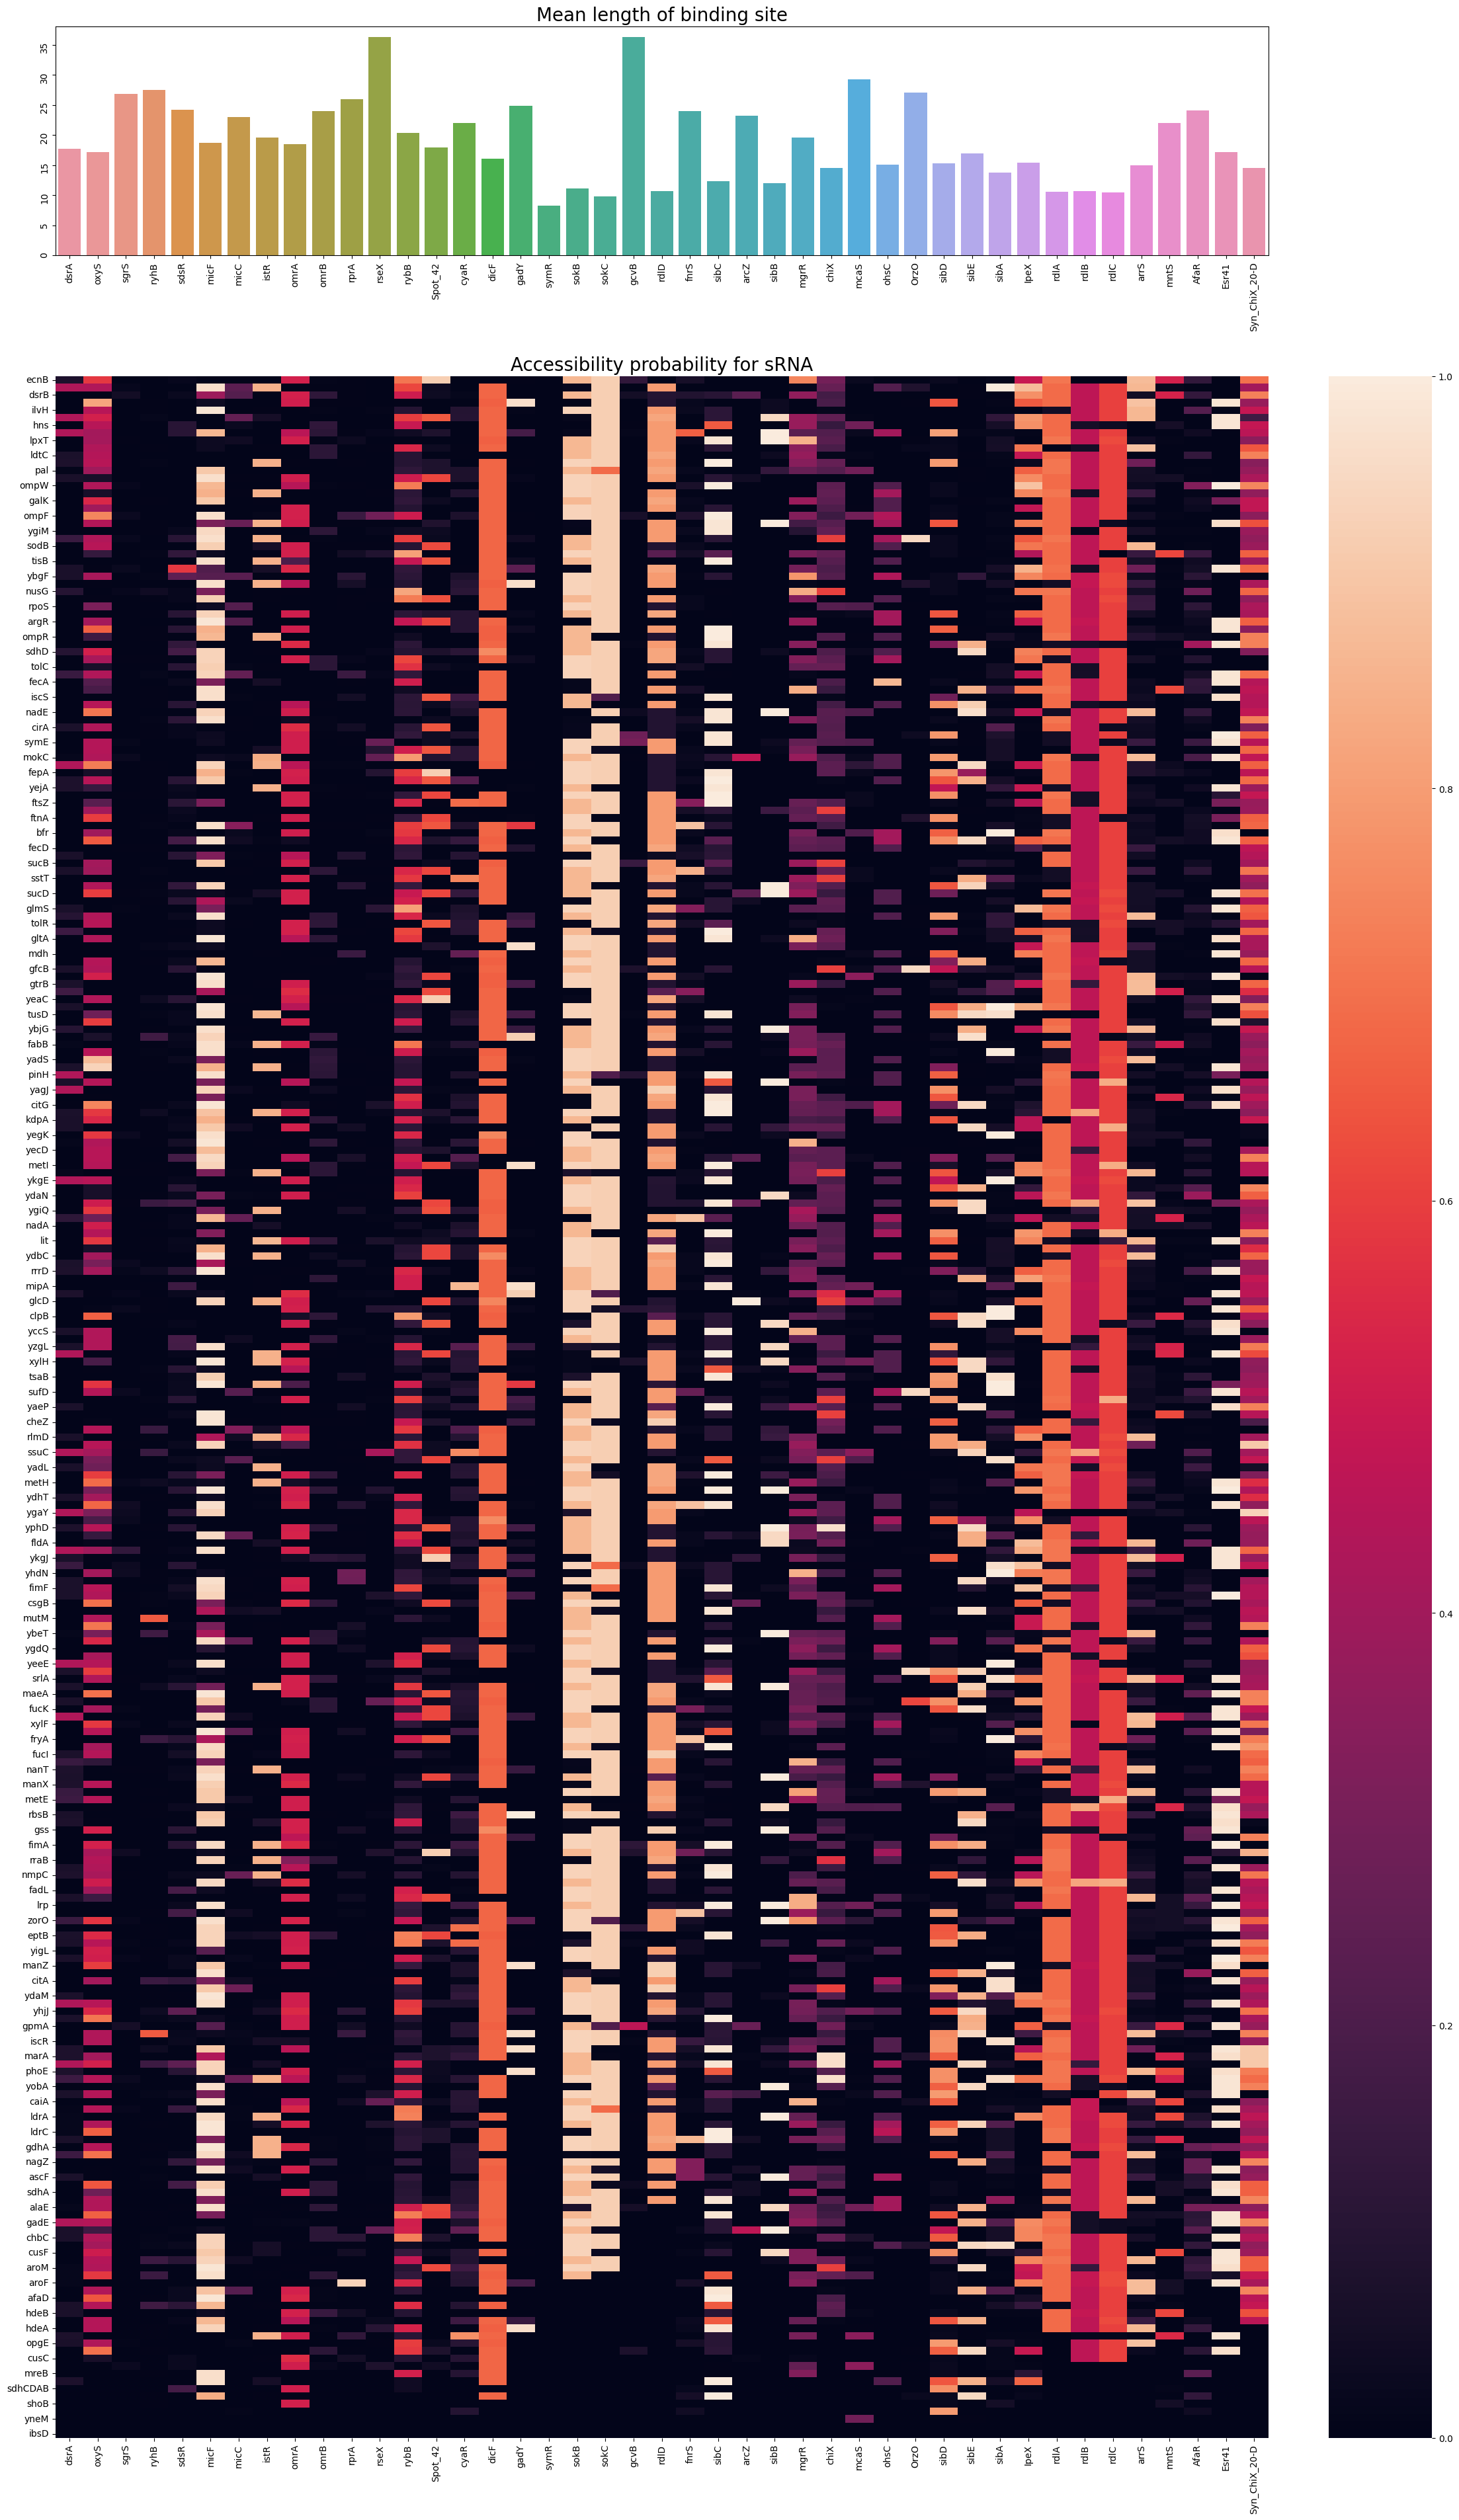

In [42]:
fig, axs = plt.subplots(2,1,figsize=(22, 38), gridspec_kw={'height_ratios': [1, 9]}, constrained_layout=True)
fig.subplots_adjust(hspace=0.5)

sns.barplot(x=subseq.columns, y=subseq.mean(axis=0), ax=axs[0]) #, order=[l.label1._text for l in cax.ax_heatmap.get_xaxis().majorTicks])
# sns.barplot(specificity.sum(axis=0), ax=axs[0]) #, order=[l.label1._text for l in cax.ax_heatmap.get_xaxis().majorTicks])
axs[0].tick_params(rotation=90) #, labelsize=7)
axs[0].set_title('Mean length of binding site', fontsize=20)

sns.heatmap(pus2, ax=axs[1], vmin=np.min([pus1.min(), pus2.min()]), vmax=np.max([pus1.max(), pus2.max()]))
axs[1].set_title('Accessibility probability for sRNA', fontsize=20)

plt.savefig('data/figs/mRNA_official_accessibility_sRNA.jpg')

